# End-to-End RevOps & Customer Behavior Analysis for Retail Growth Optimization

In [1]:
# Package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score, ConfusionMatrixDisplay
from lifelines import KaplanMeierFitter
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx



plt.style.use('bmh')
sns.set_theme(style=('ticks'), palette=('muted'))

# DATA IMPORT

In [3]:
# Data import (2 sheets)
df2009 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2010 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

df2009['dataset_year'] = '2009-2010'
df2010['dataset_year'] = '2010-2011'

# Combine 2 sheets
df = pd.concat([df2009, df2010], ignore_index=True)

# Stansardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
print(f'Dataframe shape: {df.shape[0]} rows, {df.shape[1]} columns')
df.head()

Dataframe shape: 1067371 rows, 9 columns


,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,dataset_year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-2010
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-2010
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-2010
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-2010
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-2010


In [ ]:
# Data summary
print('DATA OVERVIEW')
print(f'Data type: {df.info()}')
print(f'Summary statistics: {df.describe()}')
print(f'Null values check: {df.isna().sum()}')

DATA OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   invoice       1067371 non-null  object        
 1   stockcode     1067371 non-null  object        
 2   description   1062989 non-null  object        
 3   quantity      1067371 non-null  int64         
 4   invoicedate   1067371 non-null  datetime64[ns]
 5   price         1067371 non-null  float64       
 6   customer_id   824364 non-null   float64       
 7   country       1067371 non-null  object        
 8   dataset_year  1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 73.3+ MB
Data type: None
Summary statistics:            quantity                    invoicedate         price  \
count  1.067371e+06                        1067371  1.067371e+06   
mean   9.938898e+00  2011-01-02 21:13:55.3940285

# DATA WRANGLING AND FEATURE ENGINEERING

In [4]:
# Copy dataset for cleaning
clean_df = df.copy()

In [5]:
# DATA CLEANING STEPS
print("Initial Data Shape:", df.shape)

# 1. Invoice: Change to string 

clean_df['invoice'] = clean_df['invoice'].astype(str)


# 2. StockCode: Change to string

clean_df['stockcode'] = clean_df['stockcode'].astype(str)


# 3. Description: Comprehensive cleaning

# Create placeholder for null values before changing datatype to string
clean_df['description'] = clean_df['description'].fillna('Unspecified').astype(str)
# Remove leading and trailing spaces
clean_df['description'] = clean_df['description'].str.strip()
# Replace placeholder strings like '????' or 'unknown' with a standard value
invalid_descriptions = ['????', 'unknown', '?', 'null', 'none']
clean_df['description'] = clean_df['description'].replace(invalid_descriptions, 'Unspecified', regex=False)

# After initial cleaning, check if there are empty strings or minimal strings and replace them
clean_df['description'] = np.where(
    clean_df['description'].str.len() < 2, # If description is too short or empty
    'Unspecified',
    clean_df['description']
)


# 4. Quantity: Convert to integer and clean negative values

# First, ensure it's numeric, coercing errors to NaN
clean_df['quantity'] = pd.to_numeric(clean_df['quantity'], errors='coerce')
# Filter out rows with negative quantities (cancellations are handled by invoice 'C')
clean_df = clean_df[clean_df['quantity'] >= 0]
# Convert to integer and drop any remaining NaN values introduced by to_numeric
clean_df = clean_df.dropna(subset=['quantity'])
clean_df['quantity'] = clean_df['quantity'].astype(int)


# 5. InvoiceDate: Convert to datetime


clean_df['invoicedate'] = pd.to_datetime(clean_df['invoicedate'], errors='coerce')
# Drop rows where datetime conversion failed (invalid dates)
clean_df = clean_df.dropna(subset=['invoicedate'])


# 6. Price: Convert to float and clean negative values

# Convert to numeric, coercing errors to NaN
clean_df['price'] = pd.to_numeric(clean_df['price'], errors='coerce')
# Filter out rows with negative or zero prices
clean_df = clean_df[clean_df['price'] > 0]
# Drop any rows where price is still NaN after conversion
clean_df = clean_df.dropna(subset=['price'])


# 7. Customer ID: Convert to string and drop nulls

# Drop rows where Customer ID is null (these are unidentifiable customers)
clean_df = clean_df.dropna(subset=['customer_id'])
# Convert to integer first to remove decimal points, then to string for consistency
clean_df['customer_id'] = clean_df['customer_id'].astype(int).astype(str)


# 8. Country: Convert to string and clean

clean_df['country'] = clean_df['country'].astype(str)
# Remove leading and trailing spaces from country names
clean_df['country'] = clean_df['country'].str.strip()
# Replace any placeholder or missing indicators in Country to NA. This prevents skewness in modelling and category misrepresntation
clean_df['country'] = clean_df['country'].replace('Unspecified', pd.NA)
clean_df['country'] = clean_df['country'].replace('EIRE', 'Ireland')



# Remove rows where Invoice starts with 'C' (cancellations/credit notes)
clean_df = clean_df[~clean_df['invoice'].str.startswith('C', na=False)]


# Create TotalSales Column

clean_df['totalsales'] = clean_df['quantity'] * clean_df['price']


# Data Validation & Final Report

print("\n-Data Cleaning Complete-\n")
print("Final Data Shape:", clean_df.shape)

# Number and % of rows removed after cleaning
original_rows = df.shape[0]
cleaned_rows = clean_df.shape[0]
rows_removed = original_rows - cleaned_rows
pct_removed = (rows_removed / original_rows) * 100

print(f"Rows removed: {rows_removed} ({pct_removed:.2f}%)")

print("\n-Final Data Types-")
print(clean_df.dtypes)

print("\n-Sample of Cleaned Data-")
print(clean_df.head())

# Export cleaned dataframe as a CSV file
# clean_df.to_csv('online_retail_cleaned2.csv', index=False)


Initial Data Shape: (1067371, 9)

-Data Cleaning Complete-

Final Data Shape: (805549, 10)
Rows removed: 261822 (24.53%)

-Final Data Types-
invoice                 object
stockcode               object
description             object
quantity                 int64
invoicedate     datetime64[ns]
price                  float64
customer_id             object
country                 object
dataset_year            object
totalsales             float64
dtype: object

-Sample of Cleaned Data-
  invoice stockcode                          description  quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041          RECORD FRAME 7" SINGLE SIZE        48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          invoicedate  price customer_id         country dataset_year  \
0 2009-12-01 07

# POST WRANGLING DATA HEALTH CHECKS

In [5]:
# Check if dataset is complete
print(f'Number of empty entry in each column:')
clean_df.isna().sum()

Number of empty entry in each column:


invoice           0
stockcode         0
description       0
quantity          0
invoicedate       0
price             0
customer_id       0
country         521
dataset_year      0
totalsales        0
dtype: int64

In [6]:
# Descriptive statistics for numerical columns
print(f'Descriptive statistics for numerical columns')
clean_df[['price', 'quantity', 'totalsales']].describe()

Descriptive statistics for numerical columns


,price,quantity,totalsales
count,805549.000000,805549.000000,805549.000000
mean,3.206561,13.290522,22.026505
std,29.199173,143.634088,224.041928
min,0.001000,1.000000,0.001000
25%,1.250000,2.000000,4.950000
50%,1.950000,5.000000,11.850000
75%,3.750000,12.000000,19.500000
max,10953.500000,80995.000000,168469.600000


Total number of transaction: 805,549

Average price: 1.95
Highest price: 10,953
Lowest Price: 0.001

Average quantity: 5
Highest quantity: 80,995
Lowest quantity: 1

Average revenue: 11.85
Highest revenue: 168,469
Lowest revenue: 0.001



In [5]:
# Time period of dataset
min_date = clean_df['invoicedate'].min()
max_date = clean_df['invoicedate'].max()

print(f'Dataset time period is from {min_date} to {max_date}')
print(f'Dataset timeframe is {max_date-min_date}')


Dataset time period is from 2009-12-01 07:45:00 to 2011-12-09 12:50:00
Dataset timeframe is 738 days 05:05:00


Dataset time period is from 2009-12-01 to 2011-12-09 

Dataset timeframe is 738 days

In [39]:
# Customer data

cutomer_count = clean_df['customer_id'].nunique()
print(cutomer_count)
print(f'Customer spend (statistics):')
print(clean_df.groupby('customer_id')['invoice'].nunique().describe())

# One-time purchase
onetime_cust = (clean_df.groupby('customer_id')['invoice'].nunique() == 1).sum()
print(onetime_cust)

pct_onetimecust = onetime_cust / cutomer_count * 100
print(f'{pct_onetimecust:.2f} %')

5878
Customer spend (statistics):
count    5878.000000
mean        6.289384
std        13.009406
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       398.000000
Name: invoice, dtype: float64
1623
27.61 %


There are a total of 5,878 unique customers.

The average number of transaction by customers is 3, the highest being 398, and the lowest 1.

There are one-time buyers (1,623 unique customers), and they make up 27.6% of total unique customers

In [7]:
# Financial data validation
clean_df['fin_dataval'] = clean_df['quantity'] * clean_df['price']
val_match = (clean_df['fin_dataval'] == clean_df['totalsales']).all()

print(f'Financial data validation: {val_match}')

if val_match:
    clean_df=clean_df.drop(columns=['fin_dataval'])

Financial data validation: True


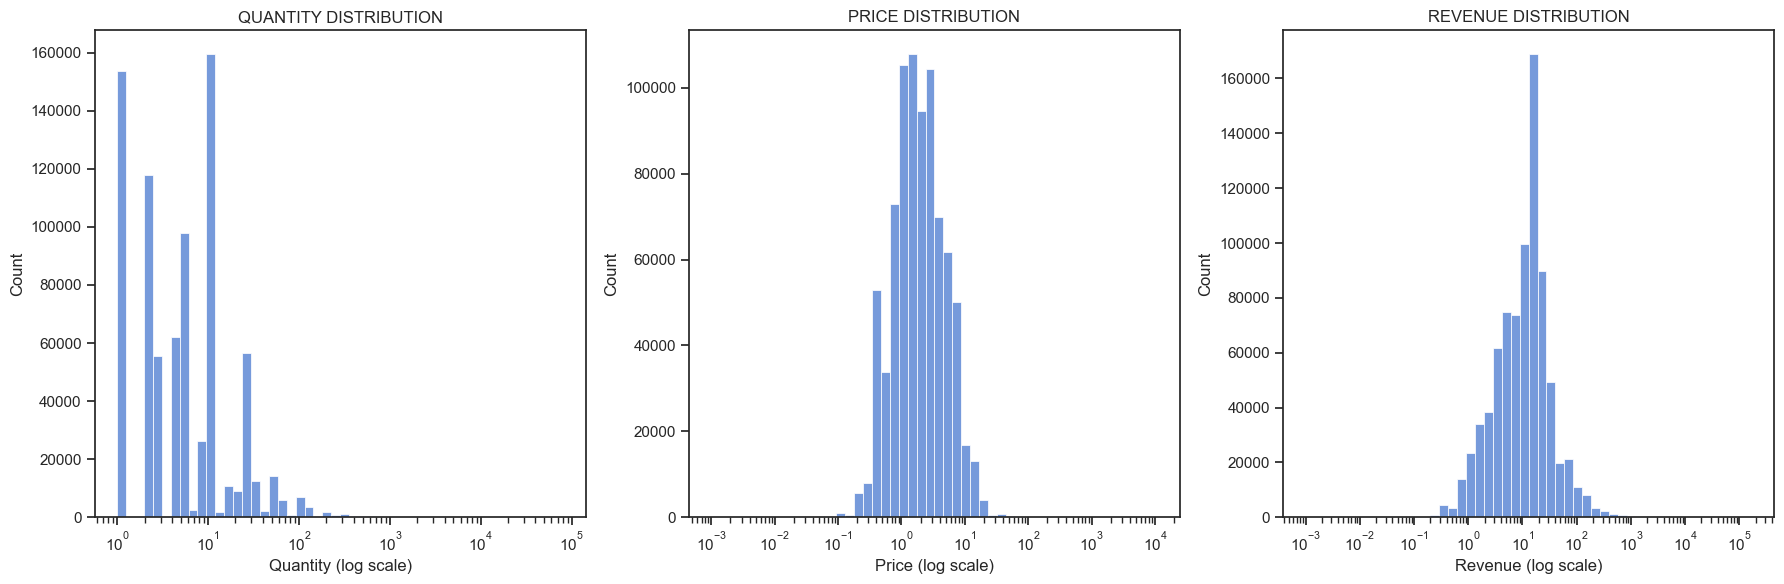

In [8]:
# Visualization for Quantity, Price, and Revenue
fig, ax= plt.subplots(1, 3, figsize=(18,6))

sns.histplot(clean_df['quantity'], bins=50, ax=ax[0], log_scale=True)
ax[0].set_title('QUANTITY DISTRIBUTION')
ax[0].set_xlabel('Quantity (log scale)')

sns.histplot(clean_df['price'], bins=50, ax=ax[1], log_scale=True)
ax[1].set_title('PRICE DISTRIBUTION')
ax[1].set_xlabel('Price (log scale)')

sns.histplot(clean_df['totalsales'], bins=50, ax=ax[2], log_scale=True)
ax[2].set_title('REVENUE DISTRIBUTION')
ax[2].set_xlabel('Revenue (log scale)')


plt.tight_layout()
plt.show()

DISTRIBUTION INSIGHTS

1. QUANTITY: There are more customers purchasing between 1-10 volume when compared to bulk buyers. This means sales volume is driven by single-item or small basket items. 

2. PRICE: Most prices are around 10-100. There are few prices in 1000 and above categories. There is a core catalog of low-to-mid priced products with a few expensive outliers.

3. REVENUE: Most of the revenue comes from mid-value transactions, not from extreme bulk or extreme price items.

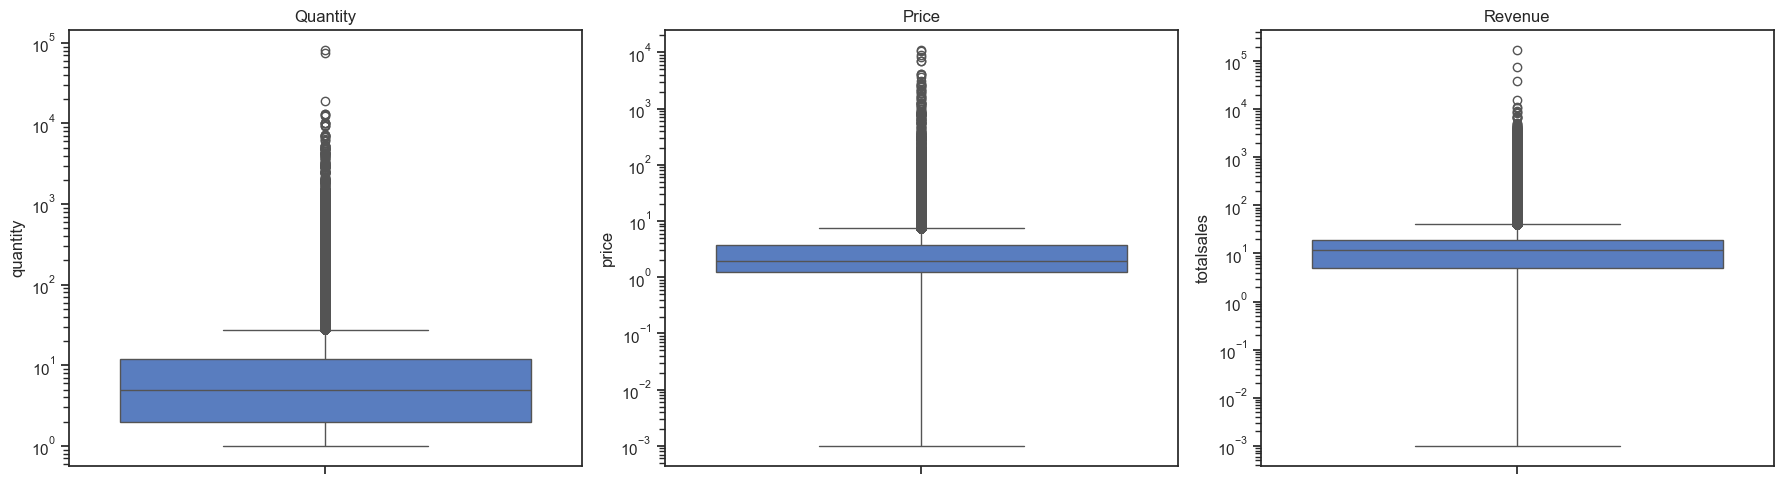

In [ ]:
# Additional distribution of financial data
fig, ax = plt.subplots(1,3, figsize=(18,5))

sns.boxplot(data=clean_df, y='quantity', ax=ax[0])
ax[0].set_title('Quantity')
ax[0].set_yscale('log')

sns.boxplot(data=clean_df, y='price', ax=ax[1])
ax[1].set_title('Price')
ax[1].set_yscale('log')

sns.boxplot(data=clean_df, y='totalsales', ax=ax[2])
ax[2].set_title('Revenue')
ax[2].set_yscale('log')

plt.tight_layout()
plt.show()

Additional Quantity, Price, Revenue distribution (Above).

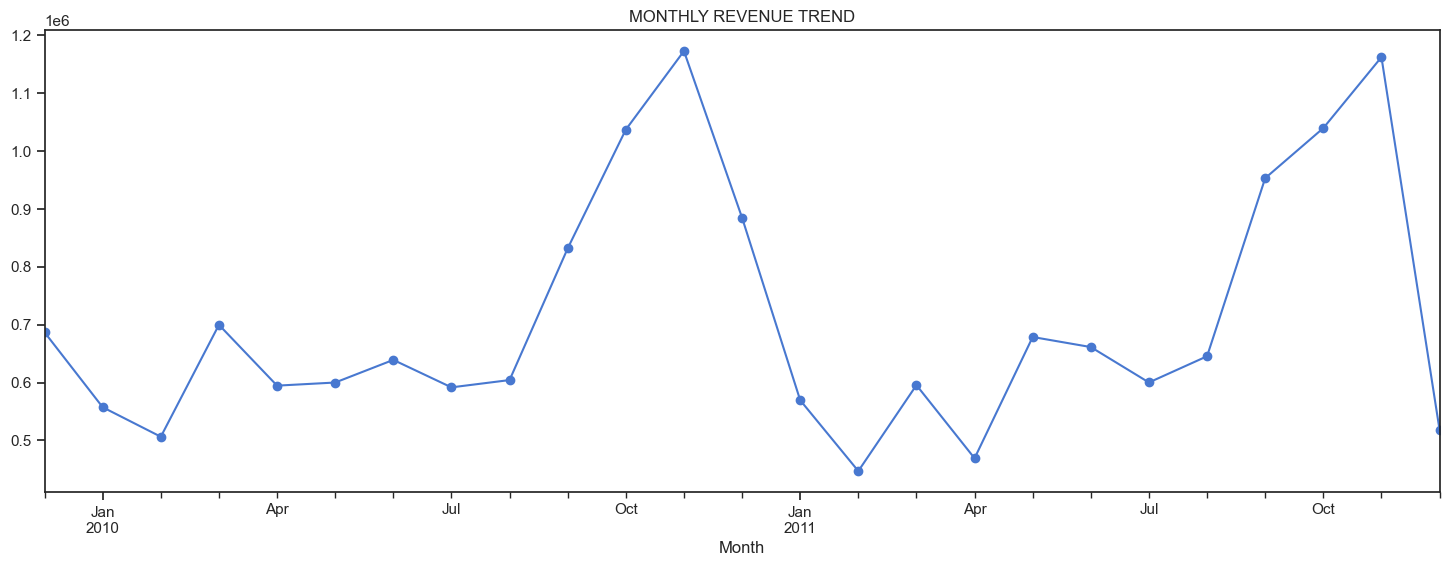

In [6]:
# Month time period and group revenue by month
clean_df['invoicemonth'] = clean_df['invoicedate'].dt.to_period('M')
revenue_m = clean_df.groupby('invoicemonth')['totalsales'].sum()

plt.figure(figsize=(18,6))
revenue_m.plot(kind='line', marker='o')
plt.title('MONTHLY REVENUE TREND')
plt.xlabel('Month')
plt.show()



MONTH OVER MONTH REVENUE INSIGHT

Despite extreme revenue dips in the months Feb(2010 & 2011), and April 2011, most months saw steady revenue growth and sharp peaks in the last quarters of both years. 

It is important to note that 2010's peak was higher than 2011's peak. 

The highest monthly revenue of all time was in November 2010 at £1,172,336. While lowest was in February 2011 at £447,137.

# DIAGNOSTIC ANALYSIS ON SALES TREND

There were peak months in revenue. Considering the overall sales trends, these peaks are anomallies. Diagnostic analysis will be carried out to understand the underlying cause of the peak months in both years. 

To identify the root cause of sharp steady increase in the peak months, these hypothesis will be tested

1. New high-spenders came on board during peak month
2. Product-led growth like more new season-themed products were bought and in large quantities
3. A successful marketing blitz (translates to large percentage of new customers) or, successful upsell/cross-sell or retention campaigns (translates to large percentage of existing customers)

In [7]:
# Divide monthly revenue into peak, mid, and low timelines
sorted_revm= revenue_m.sort_values(ascending=False)

peak_month = sorted_revm.nlargest(7).index.to_list()
mid_month = sorted_revm.iloc[7:14].index.to_list()
low_month = sorted_revm.tail(2).index.to_list()
print(sorted_revm)

invoicemonth
2010-11    1172336.042
2011-11    1161817.380
2011-10    1039318.790
2010-10    1036680.000
2011-09     952838.382
2010-12     884591.890
2010-09     831615.001
2010-03     699608.991
2009-12     686654.160
2011-05     678594.560
2011-06     661213.690
2011-08     645343.900
2010-06     639066.580
2010-08     604242.650
2011-07     600091.011
2010-05     599985.790
2011-03     595500.760
2010-04     594609.192
2010-07     591636.740
2011-01     569445.040
2010-01     557319.062
2011-12     518210.790
2010-02     506371.066
2011-04     469200.361
2011-02     447137.350
Freq: M, Name: totalsales, dtype: float64


HYPOTHESIS 1

Index(['14096', '15061', '15838', '16684'], dtype='object', name='customer_id')


Text(0.5, 0, 'Customer ID')

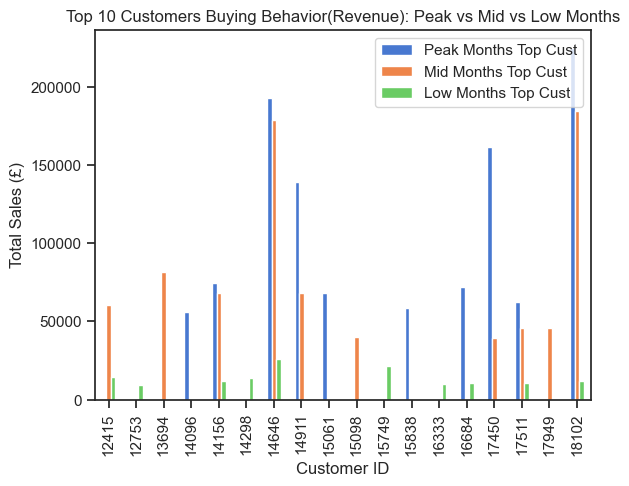

In [8]:
# Top customers in peak, mid, and low months
peak_revm = (clean_df[clean_df['invoicemonth'].isin(peak_month)]).groupby('customer_id')['totalsales'].sum().nlargest(10)
mid_revm = (clean_df[clean_df['invoicemonth'].isin(mid_month)]).groupby('customer_id')['totalsales'].sum().nlargest(10)
low_revm = (clean_df[clean_df['invoicemonth'].isin(low_month)]).groupby('customer_id')['totalsales'].sum().nlargest(10)

# See new high spenders in peak months that were not in mid months
top_new_cust = peak_revm.index.difference(mid_revm.index)
print(top_new_cust)
#print(peak_revm)
#print(mid_revm)
# Group top customers by time period
top_customers_df = pd.DataFrame({
    'Peak Months Top Cust': peak_revm,
    'Mid Months Top Cust': mid_revm,
    'Low Months Top Cust': low_revm
}).fillna(0)

# Visualize
top_customers_df.plot(kind='bar')
plt.title("Top 10 Customers Buying Behavior(Revenue): Peak vs Mid vs Low Months")
plt.ylabel("Total Sales (£)")
plt.xlabel("Customer ID")

There were 4 new high-spenders on board in the peak months (customers: '14096', '15061', '15838', '16684'). These top customers spent more money when compared to the high-spenders they replaced in mid months. Though, the revenue difference was not very significant (+£27,670). This indicates peak months was not due to new high spenders on board.

Descriptive statistics of top products purchased by top customers in peak months:             price
count  4706.000000
mean      7.507167
std      75.511737
min       0.040000
25%       1.250000
50%       2.460000
75%       4.250000
max    2736.160000


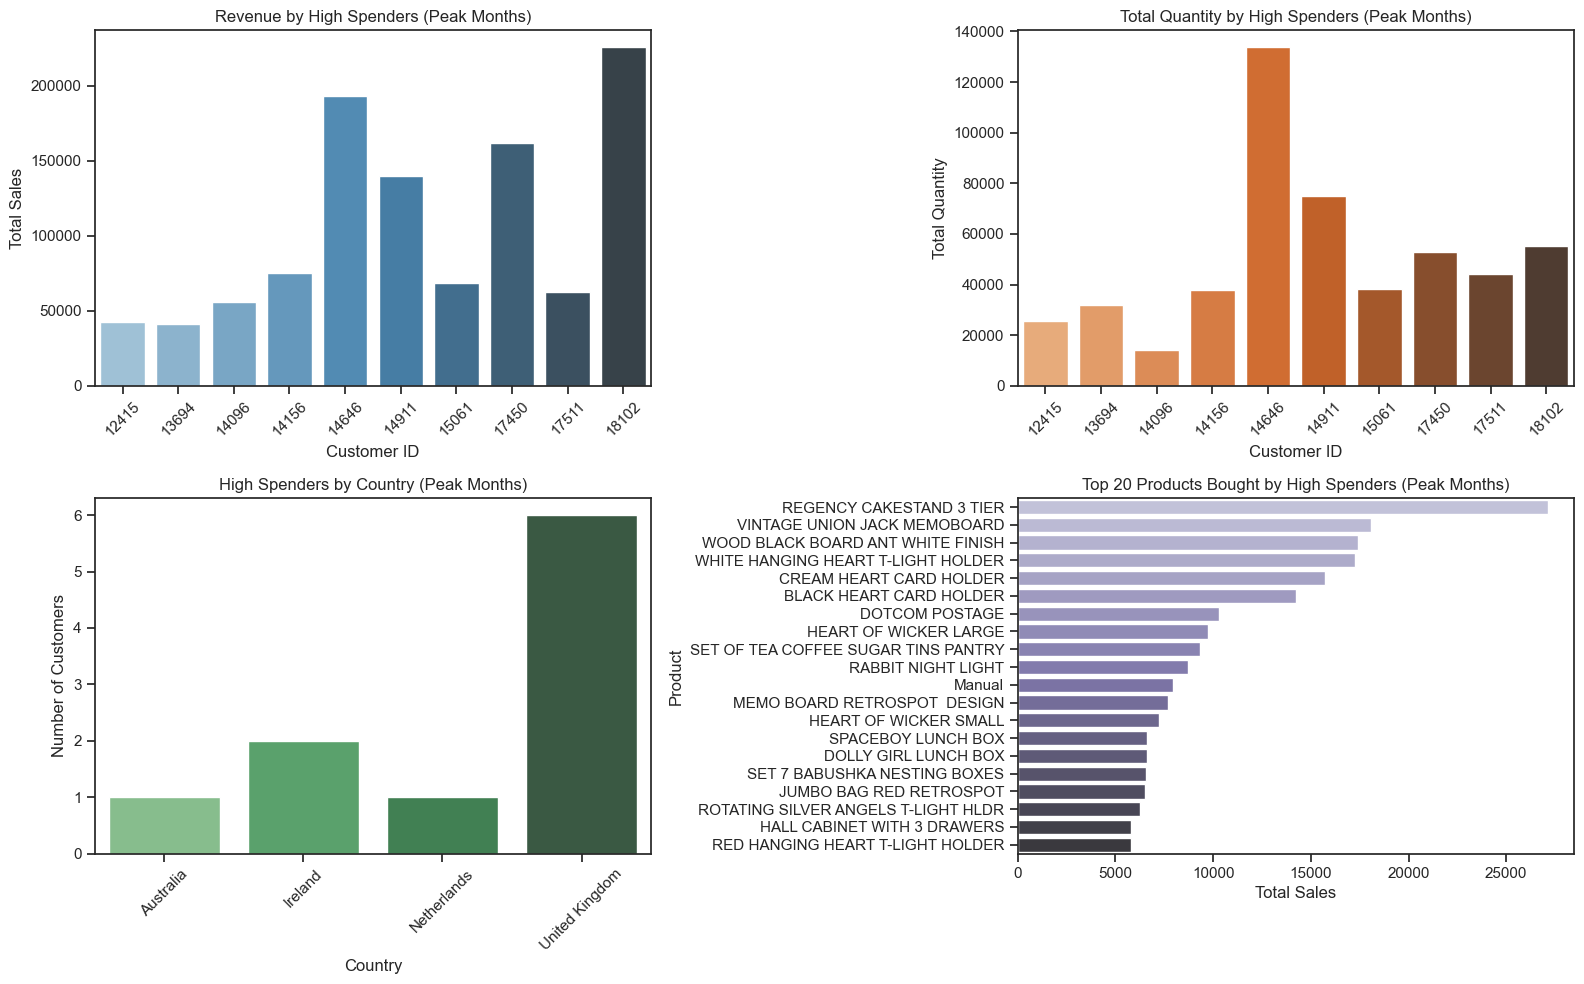

In [9]:
# High spenders dataset restricted to peak months
high_spenders = ['18102', '17511', '17450', '15061', '14911', '14646', '14156', '14096', '13694', '12415']
high_sp_df = clean_df[(clean_df['customer_id'].isin(high_spenders)) &(clean_df['invoicemonth'].isin(peak_month))]

# Summary by customer
high_spen_summary = (high_sp_df.groupby('customer_id').agg(
        totalsales=('totalsales', 'sum'),
        totalquantity=('quantity', 'sum'),
        country=('country', lambda x: list(x.unique()))).reset_index())

# Top spenders countries 
country_counts = (high_sp_df.groupby('country')['customer_id'].nunique().reset_index(name='num_customers'))

# Top 20 products
top_products = (high_sp_df.groupby('description')['totalsales'].sum().sort_values(ascending=False).head(20).reset_index())
topp = high_sp_df[['description', 'price']].drop_duplicates()
print(f'Descriptive statistics of top products purchased by top customers in peak months:{topp.describe()}')
#sns.histplot(topp['price'], bins=10)
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Total Sales by Customer
sns.barplot(data=high_spen_summary,x='customer_id', y='totalsales',ax=axes[0,0], palette="Blues_d")
axes[0,0].set_title("Revenue by High Spenders (Peak Months)")
axes[0,0].set_xlabel("Customer ID")
axes[0,0].set_ylabel("Total Sales")
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Total Quantity by Customer
sns.barplot(
    data=high_spen_summary,
    x='customer_id', y='totalquantity',
    ax=axes[0,1], palette="Oranges_d"
)
axes[0,1].set_title("Total Quantity by High Spenders (Peak Months)")
axes[0,1].set_xlabel("Customer ID")
axes[0,1].set_ylabel("Total Quantity")
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Countries of High Spenders
sns.barplot(
    data=country_counts,
    x='country', y='num_customers',
    ax=axes[1,0], palette="Greens_d"
)
axes[1,0].set_title("High Spenders by Country (Peak Months)")
axes[1,0].set_xlabel("Country")
axes[1,0].set_ylabel("Number of Customers")
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Top 20 Products by Sales
sns.barplot(
    data=top_products,
    x='totalsales', y='description',
    ax=axes[1,1], palette="Purples_d"
)
axes[1,1].set_title("Top 20 Products Bought by High Spenders (Peak Months)")
axes[1,1].set_xlabel("Total Sales")
axes[1,1].set_ylabel("Product")

plt.tight_layout()
plt.show()


To further understand high-spenders in the peak months, we see the amount each spent, their country, quantity and the top products they purchased.

Most consistent high spenders spent above £50k- £200k. The quantity bought differs by customers, most customers by low-mid priced products (£1-£250) in bulk so the minimum quantity bought was 26k. Top spenders are from UK, Ireland, Australia, Netherland. The categories of the top products by high spenders are Home Décor & Storage (35%), Kitchen & Dining (25%), Giftware & Decorative Items (30%), Miscellaneous and Signage (10%).

Takeaway: High spenders are bulk buyers mostly from the UK. They mostly buy Home Décor, Storage, Kitchen, Dining, Giftware, Decorative Items. They purchase low-mid priced products with very few exceptions that buy high priced products (£2k+). This indicates that high spenders are wholesalers.

HYPOTHESIS 2.

New top products in peak months that were not in mid months: Index(['CHILLI LIGHTS', 'PAPER CHAIN KIT 50'S CHRISTMAS',
       'PAPER CHAIN KIT VINTAGE CHRISTMAS',
       'ROTATING SILVER ANGELS T-LIGHT HLDR'],
      dtype='object', name='description')


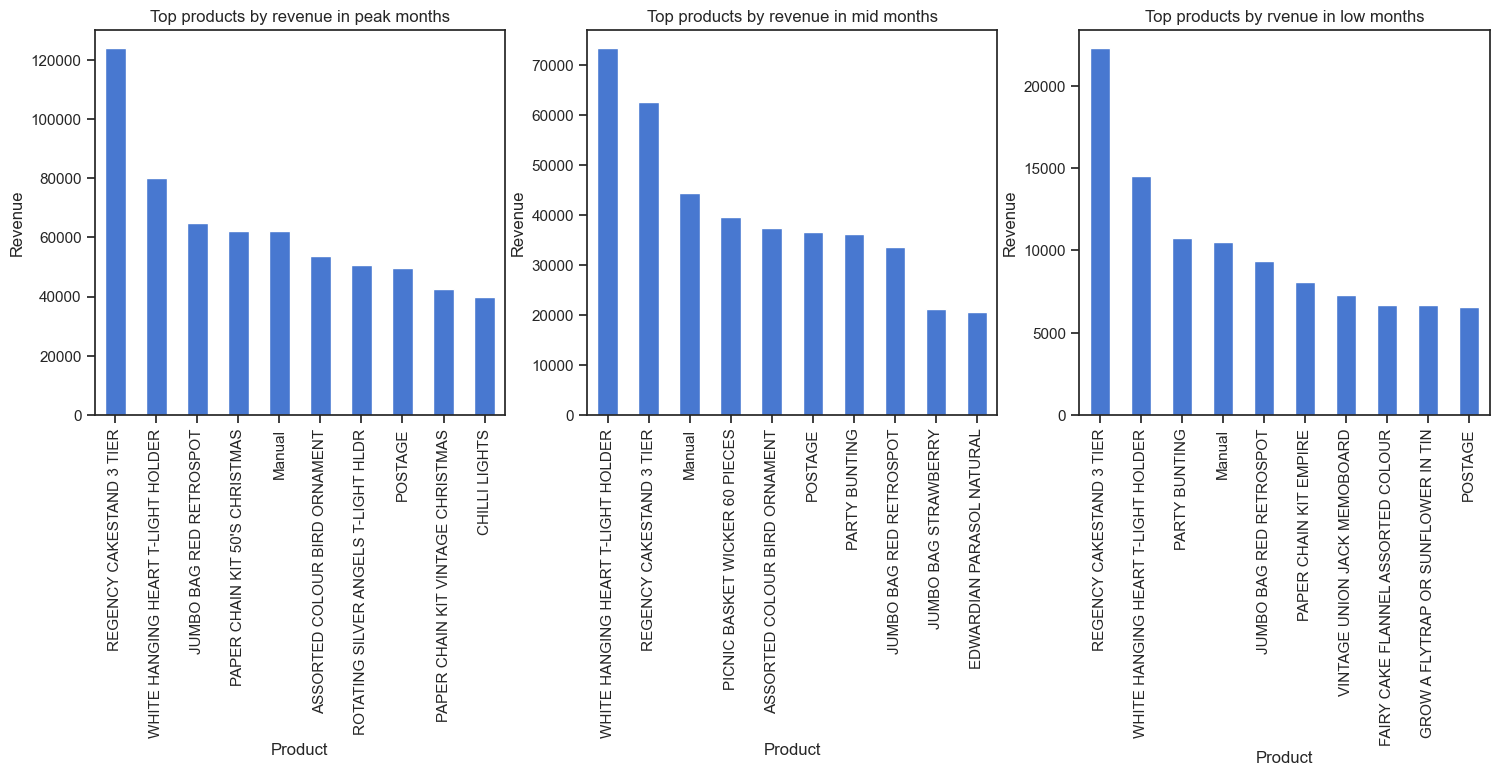

In [10]:
# Top 10 products in peak months
peak_prodm = (clean_df[clean_df['invoicemonth'].isin(peak_month)]).groupby('description')['totalsales'].sum().nlargest(10)
#print(peak_prodm)
# Top 10 products in mid months
mid_prodm = (clean_df[clean_df['invoicemonth'].isin(mid_month)]).groupby('description')['totalsales'].sum().nlargest(10)

# Top 10 products in dip season
low_prodm = (clean_df[clean_df['invoicemonth'].isin(low_month)]).groupby('description')['totalsales'].sum().nlargest(10)

# New products in peak months that are not in mid months    
top_prod = peak_prodm.index.difference(mid_prodm.index)
print(f'New top products in peak months that were not in mid months: {top_prod}')

fig, ax= plt.subplots(1,3, figsize=(18,5))

peak_prodm.plot(kind='bar', ax=ax[0])
ax[0].set_title('Top products by revenue in peak months')
ax[0].set_xlabel('Product')
ax[0].set_ylabel('Revenue')

mid_prodm.plot(kind='bar', ax=ax[1])
ax[1].set_title('Top products by revenue in mid months')
ax[1].set_xlabel('Product')
ax[1].set_ylabel('Revenue')

low_prodm.plot(kind='bar', ax=ax[2])
ax[2].set_title('Top products by rvenue in low months')
ax[2].set_xlabel('Product')
ax[2].set_ylabel('Revenue')


plt.show()



sales volume of mid month: 2884295
Peak month sales volume: 4101934
Purchase volume increased by 42.22% in the peak months when compared to mid months


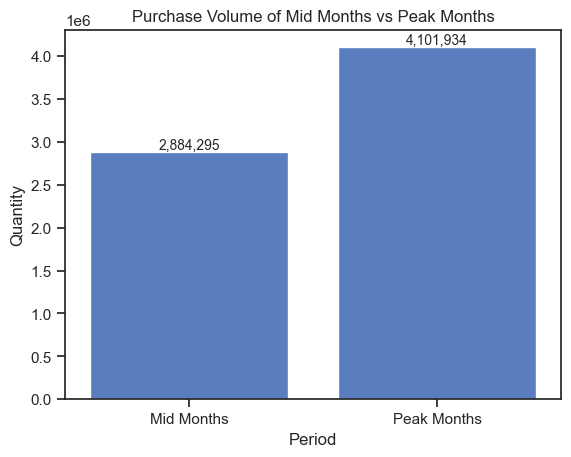

In [11]:
# Total quantity of products bought 
peak_m_quantity = clean_df[clean_df['invoicemonth'].isin(peak_month)]['quantity'].sum()
mid_m_quantity = clean_df[clean_df['invoicemonth'].isin(mid_month)]['quantity'].sum()

# Percentage difference
pct_diff_quantity = ((peak_m_quantity - mid_m_quantity) / mid_m_quantity) * 100

print(f'sales volume of mid month: {mid_m_quantity}')
print(f'Peak month sales volume: {peak_m_quantity}')
print(f'Purchase volume increased by {pct_diff_quantity:.2f}% in the peak months when compared to mid months')

volume_df = pd.DataFrame({
    'Period': ['Mid Months', 'Peak Months'],
    'Quantity': [mid_m_quantity, peak_m_quantity]
})

# Visualize volume difference
sns.barplot(x='Period', y='Quantity', data=volume_df)
plt.title('Purchase Volume of Mid Months vs Peak Months')
for i, v in enumerate(volume_df['Quantity']):
    plt.text(i, v + (0.01 * v), f"{v:,}", ha='center', fontsize=10)

There were new top products in the peak months when compared to mid months, and these new products are mainly christmas-themed but they are not high-priced. 

What influenced the peak in the various peak months was purchase volume. There is a 42% volume increase in the peak months, that was influenced by seasonal product purchase. The large volume then translates to high revenue. 


In [19]:
# new season-themed products  #price range of new season-themed products is between 2.55 - 5.75
st_prod = ['CHILLI LIGHTS', 'PAPER CHAIN KIT 50\'S CHRISTMAS',
       'PAPER CHAIN KIT VINTAGE CHRISTMAS',
       'ROTATING SILVER ANGELS T-LIGHT HLDR', 'REGENCY CAKESTAND 3 TIER']

dd = clean_df[clean_df['description'].isin(st_prod)][['description', 'price', 'quantity', 'totalsales']]
print(dd)

                                 description  price  quantity  totalsales
151           PAPER CHAIN KIT 50'S CHRISTMAS   2.95        12       35.40
303           PAPER CHAIN KIT 50'S CHRISTMAS   2.95         5       14.75
325           PAPER CHAIN KIT 50'S CHRISTMAS   2.95         6       17.70
402           PAPER CHAIN KIT 50'S CHRISTMAS   2.95        12       35.40
465           PAPER CHAIN KIT 50'S CHRISTMAS   2.95         6       17.70
...                                      ...    ...       ...         ...
1067211  ROTATING SILVER ANGELS T-LIGHT HLDR   2.55        24       61.20
1067278    PAPER CHAIN KIT VINTAGE CHRISTMAS   2.95        12       35.40
1067279       PAPER CHAIN KIT 50'S CHRISTMAS   2.95        12       35.40
1067289  ROTATING SILVER ANGELS T-LIGHT HLDR   2.55        24       61.20
1067322                        CHILLI LIGHTS   5.75         2       11.50

[8159 rows x 4 columns]


HYPOTHESIS 3.

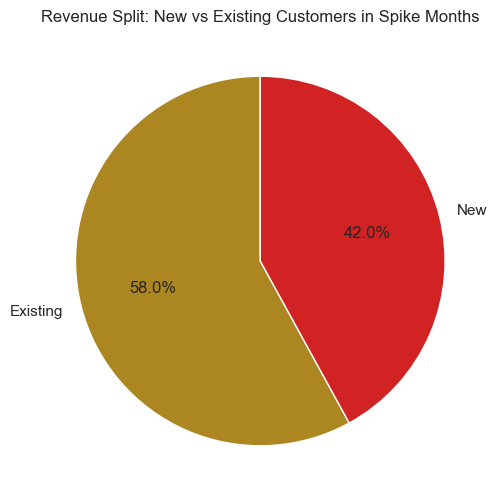

In [12]:
clean_df['firstpurchase'] = clean_df.groupby('customer_id')['invoicedate'].transform('min').dt.to_period('M')

spike_data = clean_df[clean_df['firstpurchase'].isin(peak_month)]
spike_data['customertype'] = np.where(spike_data['firstpurchase'] == spike_data['invoicemonth'], 'New', 'Existing')
rev_by_ct = spike_data.groupby('customertype')['totalsales'].sum()
#print(rev_by_ct)

plt.figure(figsize=(6,6))
plt.pie(rev_by_ct, labels= rev_by_ct.index, autopct='%1.1f%%', startangle=90, colors=["#ac8620","#D12323"])
plt.title("Revenue Split: New vs Existing Customers in Spike Months")
plt.show()


In the peak months, 58% of purchases came from existing customers, while 42%% came from new customers. 

This indicates that upsell/cross-sell or retention campaigns (targeting existing customers), and marketing blitz (targeting new customers) were both successful. If compared, marketing blitz did better because new customers patronage was almost equal with existing customers (only 8% difference) and ...

# SUMMARY

1. Peak months were product-driven. The most bought products are christmas and party products.
2. Seasonal factor also played a role in the spike. As most people only buy christmas products around the last quarter.
3. Interestingly, prices for these products are low-mid, but the volume of purchase was high. This indicates the presence of wholesale buyers and high new customers purchase volume.

# RECOMMENDATION

To replicate this success, we should: 
1. Plan inventory for seasonal products earlier.
2. Invest in targeted Account-based marketing (ABM) campaigns to acquire similar B2B clients like customer ID 18102 who are wholesale buyers and consistent.
3. Run a similar promotional campaign during the next key holiday period with better modifications done to attract more new buyers and retain existing ones.

# UNDERSTANDING CUSTOMER-REVENUE-VOLUME SPREAD

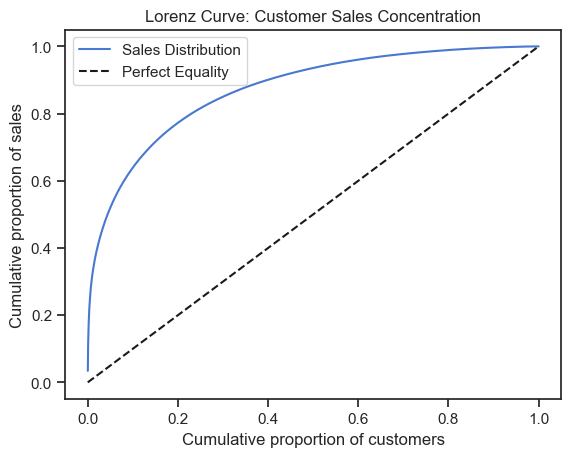

Top 20% of customers generate: 77.3% of revenue
Top 20% of customers generate: 77.2% of revenue
     customer_id  totalsales  high_spender
0          18102   608821.65             1
1          14646   528602.52             1
2          14156   313946.37             1
3          14911   295972.63             1
4          17450   246973.09             1
...          ...         ...           ...
5873       15913        6.30             0
5874       14792        6.20             0
5875       13788        3.75             0
5876       16738        3.75             0
5877       14095        2.95             0

[5878 rows x 3 columns]


In [12]:
# Total sales per customer
sales_per_customer = clean_df.groupby('customer_id')['totalsales'].sum().sort_values(ascending=False)


# Cumulative % of sales by customers
cumulative_sale = sales_per_customer.cumsum() / sales_per_customer.sum()
cumulative_customer = np.arange(1, len(cumulative_sale)+1) / len(cumulative_sale)

# Plot Lorenz curve
plt.plot(cumulative_customer, cumulative_sale, label='Sales Distribution')
plt.plot([0,1], [0,1], 'k--', label='Perfect Equality') # Reference line
plt.title('Lorenz Curve: Customer Sales Concentration')
plt.xlabel('Cumulative proportion of customers')
plt.ylabel('Cumulative proportion of sales')
plt.legend()
plt.show()

# Calculate 80/20 ratio
top_20_percent_sales = cumulative_sale.iloc[int(len(cumulative_sale)*0.2)]
print(f'Top 20% of customers generate: {top_20_percent_sales * 100:.1f}% of revenue')



# Assuming df is your transaction dataset with columns: customer_id, revenue
customer_sales = clean_df.groupby('customer_id', as_index=False)['totalsales'].sum()
customer_sales = customer_sales.sort_values('totalsales', ascending=False).reset_index(drop=True)

# calculate top 20% cutoff
n_top = int(len(customer_sales) * 0.2)
customer_sales['high_spender'] = 0
customer_sales.loc[:n_top-1, 'high_spender'] = 1

# check contribution %
pct_rev_top20 = customer_sales.loc[customer_sales['high_spender']==1, 'totalsales'].sum() / customer_sales['totalsales'].sum()
print(f"Top 20% of customers generate: {pct_rev_top20*100:.1f}% of revenue")
print(customer_sales)

# export for Tableau
customer_sales.to_csv("customer_high_spenders.csv", index=False)



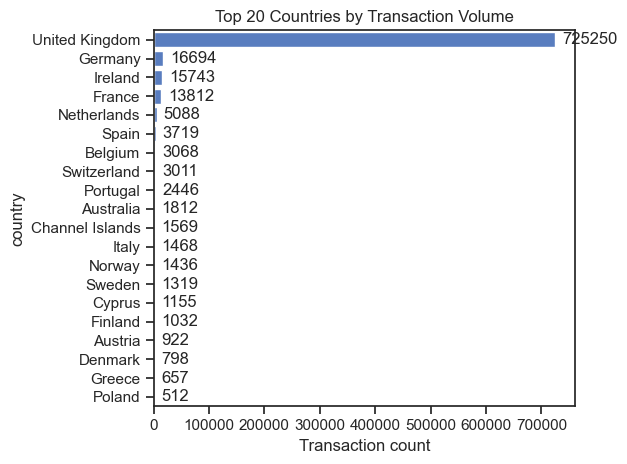

In [14]:
# Top 10 countries
country_trans = clean_df['country'].value_counts().head(20)

bar_plot = sns.barplot(x=country_trans.values, y=country_trans.index, orient='h')
plt.title('Top 20 Countries by Transaction Volume')
plt.xlabel('Transaction count')

bar_plot.bar_label(bar_plot.containers[0], fmt='%.0f', padding=5)

plt.tight_layout()
plt.show()



REVENUE-CUSTOMER DISTRIBUTION INSIGHT

The curve in the visualization above is bowed downward. This means that revenue is unevenly distributed across customers as it doesn't follow the perfect equality (reference) line. Only 20% of customers are responsible for more than three quarters of the revenue (77.3%). A minority of customers drive the majority of sales. The United Kingdom is where the majority of transactions occur. This suggests a large customer base from the UK.

RECOMENDATION

Focus on top customers by offering special deals with the aim of retention and growth.

To de-risk the business, implement strategies to increase revenue from the bottom 80% of customers.


# PRODUCT AFFINITY ANALYSIS (Market Basket Analysis)

In [ ]:
# Find products frequently bought together CSV

# Create a basket matrix (one-hot encoded)
basket = (clean_df.groupby(['invoice', 'description'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('invoice'))

# Apply Apriori algorithm
frequent_itemsets = apriori(basket.astype('bool'), min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print(rules.sort_values('lift', ascending=False))

#rules.to_csv('product_affinity2.csv', index=False)



                             antecedents  \
1      (ROSES REGENCY TEACUP AND SAUCER)   
0      (GREEN REGENCY TEACUP AND SAUCER)   
13      (SWEETHEART CERAMIC TRINKET BOX)   
12      (STRAWBERRY CERAMIC TRINKET BOX)   
14          (WOODEN FRAME ANTIQUE WHITE)   
15   (WOODEN PICTURE FRAME WHITE FINISH)   
5             (HOME BUILDING BLOCK WORD)   
4             (LOVE BUILDING BLOCK WORD)   
2                (HEART OF WICKER SMALL)   
3                (HEART OF WICKER LARGE)   
9              (LUNCH BAG  BLACK SKULL.)   
8            (LUNCH BAG SPACEBOY DESIGN)   
7                  (LUNCH BAG CARS BLUE)   
6              (LUNCH BAG  BLACK SKULL.)   
11    (RED HANGING HEART T-LIGHT HOLDER)   
10  (WHITE HANGING HEART T-LIGHT HOLDER)   

                             consequents  antecedent support  \
1      (GREEN REGENCY TEACUP AND SAUCER)            0.028564   
0      (ROSES REGENCY TEACUP AND SAUCER)            0.025237   
13      (STRAWBERRY CERAMIC TRINKET BOX)            0.03167

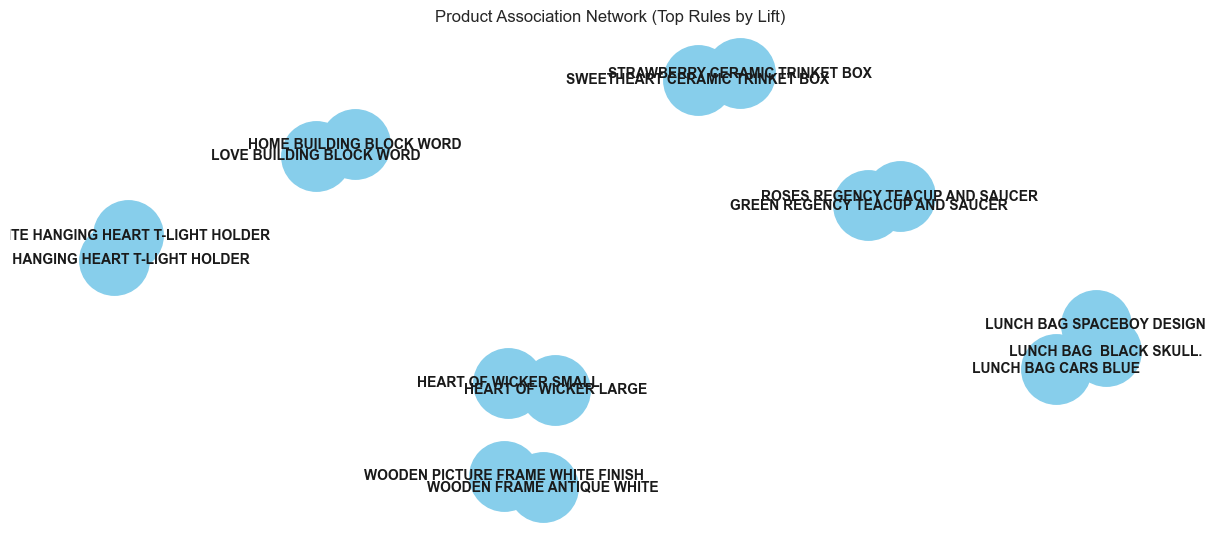

In [29]:
# Take top 20 rules by lift
top_rules = rules.sort_values('lift', ascending=False).head(20)

# Build graph
G = nx.DiGraph()
for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

# Draw
plt.figure(figsize=(12,5))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=2500, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)
plt.title("Product Association Network (Top Rules by Lift)")
plt.show()



Key Findings

Teacup Products like ROSES REGENCY & GREEN REGENCY has very strong association: if a customer buys one, there is a 70–79% chance they also buy the other. Customers are 28x more likely to purchase the pair together than by chance.

Ceramic Trinket Boxes like SWEETHEART & STRAWBERRY variants has moderate-to-strong association: buying one gives a 70% chance the other will also be purchased. This suggests good cross-selling opportunities.

Wooden Frames products like ANTIQUE WHITE & WHITE FINISH has decent association: 56% confidence, lift - 12. Customers often buy frames in complementary styles.

BUSINESS RECOMMENDATIONS

- Bundling Strategy: Offer “Teacup & Saucer Sets” combining ROSES REGENCY and GREEN REGENCY. Bundle pricing could increase cart value and reduce decision friction.

- Cross-Selling Promotions: When a customer buys one ceramic trinket box, recommend the other variant at checkout e.g, “Complete your collection”. Same for wooden frames: promote a “mix & match” bundle.

- Marketing Campaigns: Highlight these popular pairs in promotional materials, loyalty offers, or email campaigns. For example: “Buy the ROSES REGENCY set, get 20% off GREEN REGENCY.”

- Store Layout and Website user experience: Place these associated items close together in stores or recommend them online (e.g., “Customers also bought…”).

EXPECTED BENEFITS

Higher average order value (AOV) from bundles.

Increased cross-sell rates through smart recommendations.

Improved customer experience by making buying decisions easier.

# CUSTOMER-LEVEL AGGREGATION (RFM ANALYSIS)

In [ ]:
# Snapshot date is set as analysis date that customers' last purchase will be compared to (1 day after latest order)
snapshot_date = clean_df['invoicedate'].max() + pd.Timedelta(days=1)

# Aggregate data at customer level
rfm_df = clean_df.groupby('customer_id').agg({
    'invoicedate' : lambda x: (snapshot_date - x.max()).days, # How long since the customers' last purchase
    'invoice' : 'nunique', # How many different purchases made
    'totalsales' : 'sum' # How much monney customers spent in total
}).reset_index()

# Rename RFM columns
rfm_df.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

# Additional RFM metrics
rfm_df['Avgordervalue'] = rfm_df['Monetary'] / rfm_df['Frequency']
rfm_df['Purchasecycle'] = rfm_df['Recency'] / (rfm_df['Frequency'] + 1)


# Customer demographics first and last purchase
customer_demographics = clean_df.groupby('customer_id'). agg({'country': 'first', 'invoicedate': ['min', 'max']})
customer_demographics.columns = ['Country', 'FirstPurchaseDate', 'LastPurchaseDate']
customer_demographics['Tenure'] = (customer_demographics['LastPurchaseDate'] - customer_demographics['FirstPurchaseDate']).dt.days

rfm_df = rfm_df.merge(customer_demographics, on='customer_id', how='left')

# Create 5 months behavioral features
last_5m_date = snapshot_date - pd.DateOffset(months=5)
recent_df = clean_df[clean_df['invoicedate'] >= last_5m_date]
recent_behavior = recent_df.groupby('customer_id').agg({
    'invoice': 'nunique',
    'price': 'sum',
    'quantity': 'sum'
}).rename(columns={'invoice': 'FreqLast5M', 'price': 'MonetaryLast5M', 'quantity': 'QuantityLast5M'})
recent_behavior['AvgOrderValueLast5M'] = recent_behavior['MonetaryLast5M'] / recent_behavior['FreqLast5M']

# Merge recent behavior with RFM
rfm_df = rfm_df.merge(recent_behavior, on='customer_id', how='left').fillna(0)

rfm_df['FreqChangeRatio'] = rfm_df['FreqLast5M'] / (rfm_df['Frequency'] / 4)  # Compare to average monthly frequency
rfm_df['ValueChangeRatio'] = rfm_df['MonetaryLast5M'] / (rfm_df['Monetary'] / 4)

print(f"RFM analysis complete. {len(rfm_df)} customers analyzed.")

# Print number of rows and columns
print('RFM DataFrame created')
print(f'Shape: {rfm_df.shape}') 
print(rfm_df.head(10))

RFM analysis complete. 5878 customers analyzed.
RFM DataFrame created
Shape: (5878, 16)
  customer_id  Recency  Frequency  Monetary  Avgordervalue  Purchasecycle  \
0       12346      326         12  77556.46    6463.038333      25.076923   
1       12347        2          8   5633.32     704.165000       0.222222   
2       12348       75          5   2019.40     403.880000      12.500000   
3       12349       19          4   4428.69    1107.172500       3.800000   
4       12350      310          1    334.40     334.400000     155.000000   
5       12351      375          1    300.93     300.930000     187.500000   
6       12352       36         10   2849.84     284.984000       3.272727   
7       12353      204          2    406.76     203.380000      68.000000   
8       12354      232          1   1079.40    1079.400000     116.000000   
9       12355      214          2    947.61     473.805000      71.333333   

          Country   FirstPurchaseDate    LastPurchaseDate  Tenur

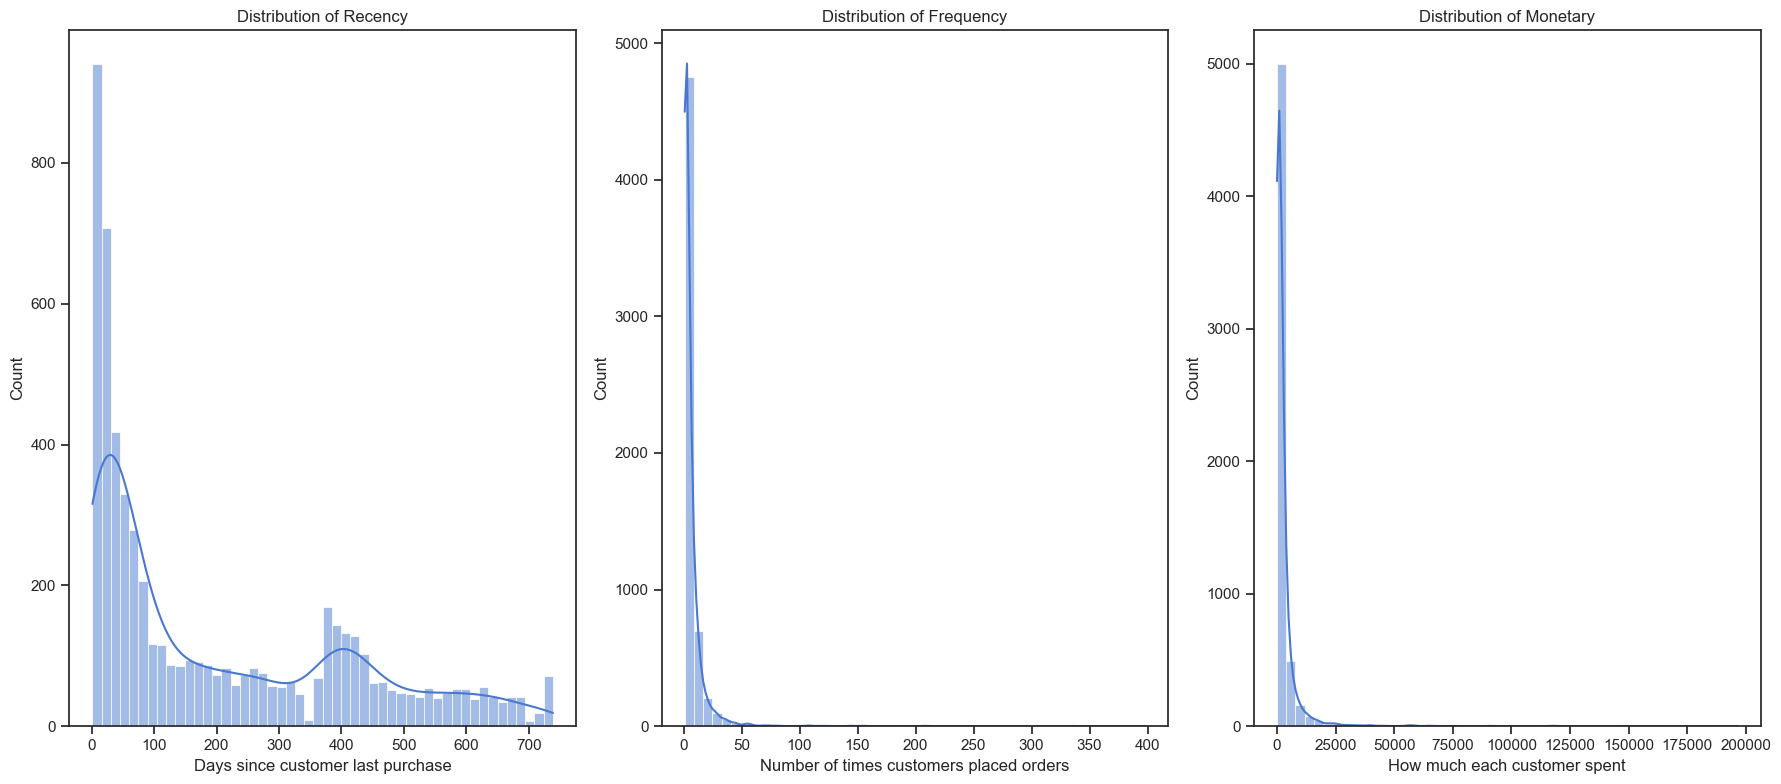

In [13]:
fig, axes = plt.subplots(1,3, figsize=(18,8))

sns.histplot(rfm_df['Recency'], bins=50, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Recency')
axes[0].set_xlabel('Days since customer last purchase')

sns.histplot(rfm_df['Frequency'], bins=50, ax=axes[1], kde=True)
axes[1].set_title('Distribution of Frequency')
axes[1].set_xlabel('Number of times customers placed orders')

sns.histplot(rfm_df[rfm_df['Monetary']< 200000]['Monetary'], bins=50, ax=axes[2], kde=True)
axes[2].set_title('Distribution of Monetary')
axes[2].set_xlabel('How much each customer spent')

plt.tight_layout()
plt.show()


RECENCY, FREQUENCY, AND MONETARY INSIGHTS

Recency refers to the days since customer last made purchase. From the Recency distribution, many customers purchased very recently. The customers that purchased last since 200 - 700 days ago might be inactive or churned customers. Customer base is fairly active but some haven't bought in a long time.

Frequency is the number of times customers purchased. The Frequency distribution shows that most customers purchased between 1-8 number of times. A small group of customers are loyal repeat buyers, while the majority are one-time or very occasional buyers.

Monetary is the amount spent. The Monetary distribution shows that most customers spent a maximum of 4k. A few customers spent huge amount (10k+ - 200k+). The highest single transaction is 349,164. These few high spenders are VIP customers. So, it is established that revenue is heavily driven by a small group of high-value customer.

Summary

Most customers are new or recent buyers but not very loyal because they buy less frequently.

A handful of customers are frequent and high spenders; they generate most of the revenue.

# RFM CUSTOMER SEGMENTATION

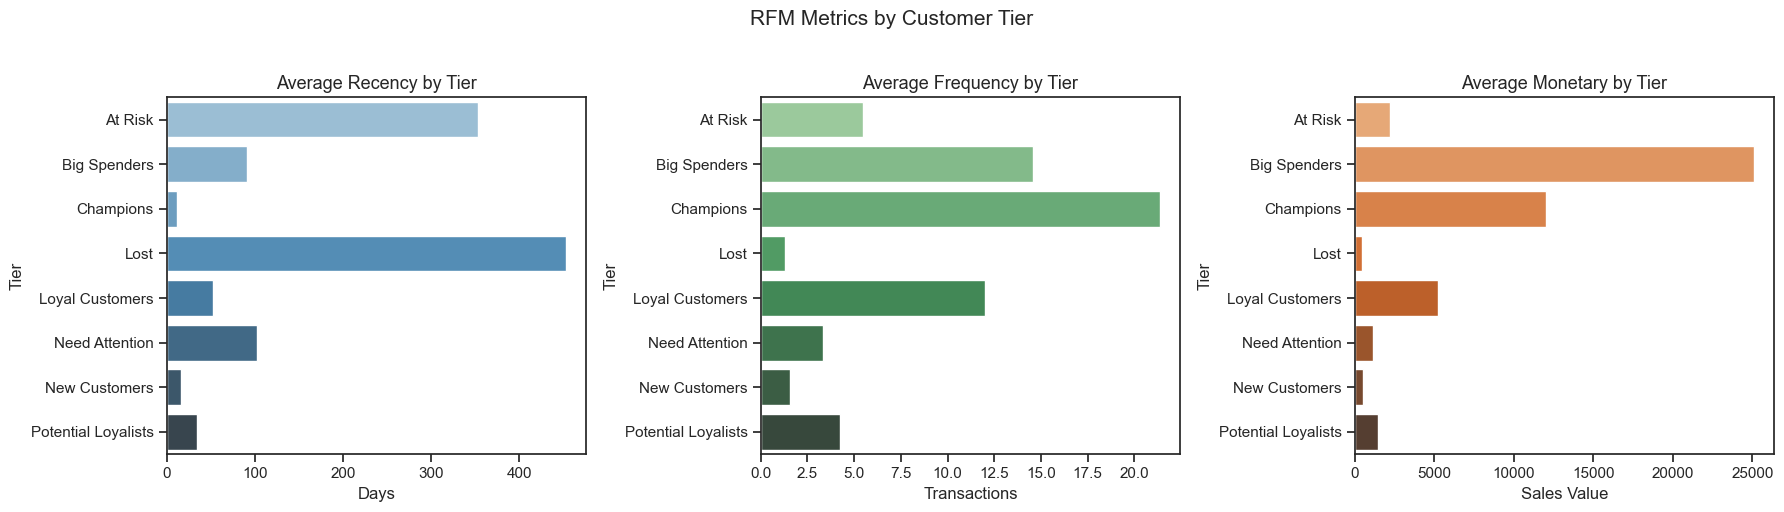

In [13]:
# Segment and label customers
rfm_df['R_Score'] = pd.cut(rfm_df['Recency'], bins=[-1,30,90,180, rfm_df['Recency'].max()], labels=[4,3,2,1])
rfm_df['F_Score'] = pd.cut(rfm_df['Frequency'], bins=[0,2,6,12, rfm_df['Frequency'].max()], labels=[1,2,3,4])
rfm_df['M_Score'] = pd.cut(rfm_df['Monetary'], bins=[0,100,1000,10000, rfm_df['Monetary'].max()], labels=[1,2,3,4])

rfm_df['ScoreGroup'] = rfm_df['R_Score'].astype(int) + rfm_df['F_Score'].astype(int) + rfm_df['M_Score'].astype(int)

# Create rules for labels or customer score
def assign_tier(row):
    # Champions: very recent, frequent, high spend
    if row['R_Score'] == 4 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Champions'
    
    # Loyal Customers: frequent and fairly recent
    elif row['F_Score'] >= 3 and row['R_Score'] >= 3:
        return 'Loyal Customers'
    
    # Big Spenders: high monetary value
    elif row['M_Score'] == 4 and row['R_Score'] >= 2:
        return 'Big Spenders'
    
    # At Risk: used to buy, now inactive
    elif row['R_Score'] == 1 and row['F_Score'] >= 2:
        return 'At Risk'
    
    # Lost Customers: old, low frequency & spend
    elif row['R_Score'] == 1 and row['F_Score'] == 1:
        return 'Lost'
    
    # New Customers: very recent but low frequency
    elif row['R_Score'] == 4 and row['F_Score'] == 1:
        return 'New Customers'
    
    # Potential Loyalists: decent recency, medium spend
    elif row['R_Score'] >= 3 and row['F_Score'] == 2 and row['M_Score'] >= 2:
        return 'Potential Loyalists'
    
    else:
        return 'Need Attention'

rfm_df['Tier'] = rfm_df.apply(assign_tier, axis=1)

    

# See average RFM in all tiers 
segment_analysis = rfm_df.groupby('Tier').agg(
    Customers=('customer_id', 'count'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean')
).round(2)

segment_analysis2 = rfm_df.groupby('Tier').agg(
    Customers=('customer_id', 'count'),
    Recency=('Recency', 'sum'),
    Frequency=('Frequency', 'sum'),
    Monetary=('Monetary', 'sum')
).reset_index()
segment_analysis2.to_csv('customer_rfm_segment.csv', index=False)

# Reset index to get Tier as column
seg_plot = segment_analysis.reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharex=False)

# Recency avg
sns.barplot(data=seg_plot, y='Tier', x='Avg_Recency', palette='Blues_d', ax=axes[0], orient='h')
axes[0].set_title("Average Recency by Tier", fontsize=13)
axes[0].set_xlabel("Days")

# Frequency avg
sns.barplot(data=seg_plot, y='Tier',  x='Avg_Frequency', palette='Greens_d', ax=axes[1], orient='h')
axes[1].set_title("Average Frequency by Tier", fontsize=13)
axes[1].set_xlabel("Transactions")

# Monetary avg
sns.barplot(data=seg_plot, y='Tier', x='Avg_Monetary', palette='Oranges_d', ax=axes[2], orient='h')
axes[2].set_title("Average Monetary by Tier", fontsize=13)
axes[2].set_xlabel("Sales Value")


plt.suptitle("RFM Metrics by Customer Tier", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()


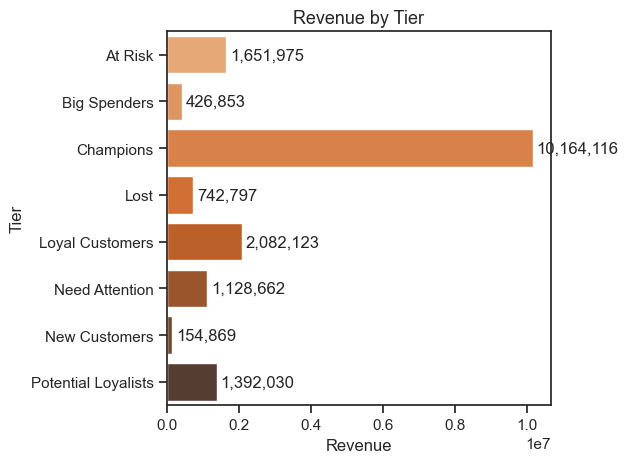

In [34]:
ax = sns.barplot(data=segment_analysis2, y='Tier', x='Monetary', palette='Oranges_d', orient='h')
plt.title("Revenue by Tier", fontsize=13)
plt.xlabel("Revenue")

for p in ax.patches:
    width = p.get_width()   # bar length
    plt.text(
        width + (0.01 * segment_analysis2['Monetary'].max()),  # little offset
        p.get_y() + p.get_height() / 2,                       # vertical center
        f'{int(width):,}',                                    # formatted label
        va='center'
    )

plt.tight_layout()
plt.show()

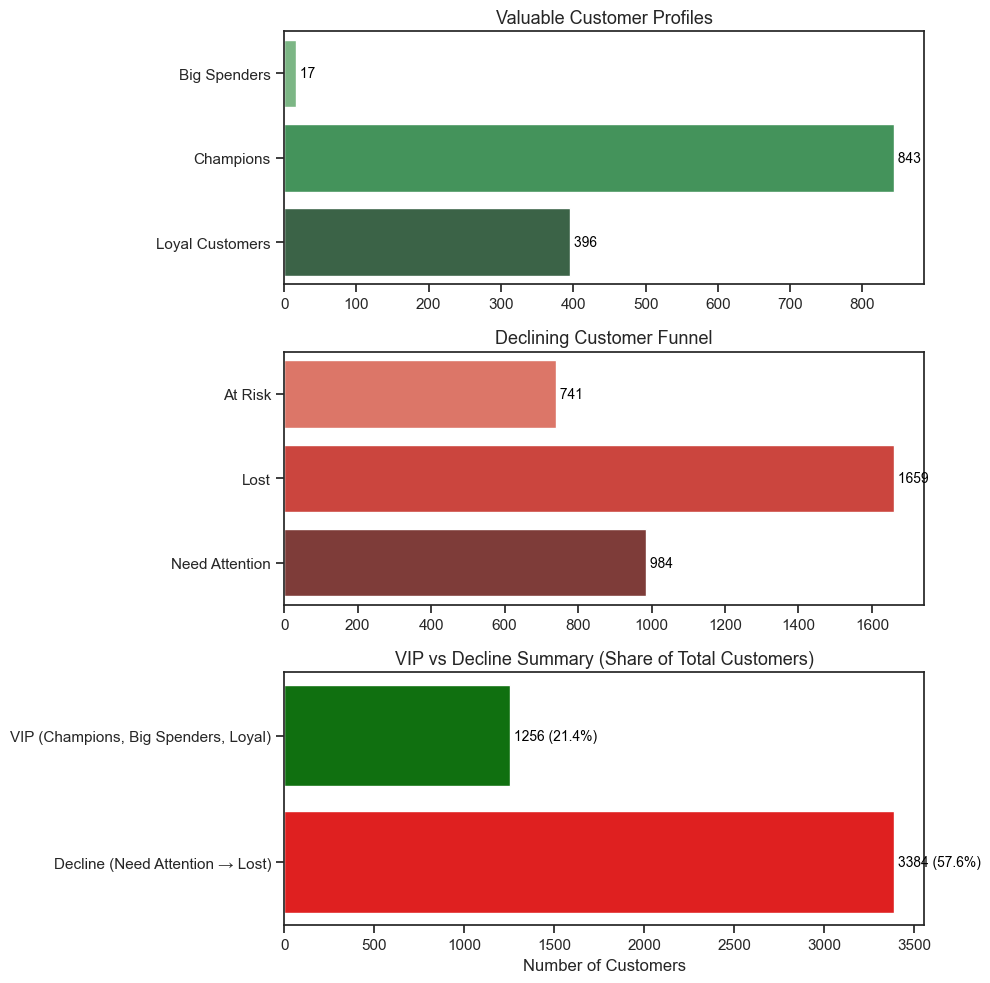

In [14]:


# Reset index so Tier is a column
seg_counts = segment_analysis.reset_index()[['Tier', 'Customers']]

# Define groups
vip_segments = ['Champions', 'Big Spenders', 'Loyal Customers']
decline_segments = ['Need Attention', 'At Risk', 'Lost']

# Filter into two groups
vip_data = seg_counts[seg_counts['Tier'].isin(vip_segments)]
decline_data = seg_counts[seg_counts['Tier'].isin(decline_segments)]

# Calculate summary (VIP vs Decline %)
total_customers = seg_counts['Customers'].sum()
vip_total = vip_data['Customers'].sum()
decline_total = decline_data['Customers'].sum()

summary_df = (
    pd.DataFrame({
        "Group": ["VIP (Champions, Big Spenders, Loyal)", "Decline (Need Attention → Lost)"],
        "Customers": [vip_total, decline_total]
    })
)
summary_df["Percent"] = (summary_df["Customers"] / total_customers * 100).round(1)

# Create stacked subplots (3 rows)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10), sharex=False)

# --- Top: VIP profiles ---
sns.barplot(data=vip_data, x='Customers', y='Tier', palette="Greens_d", ax=ax1)
ax1.set_title("Valuable Customer Profiles", fontsize=13)
ax1.set_xlabel("")
ax1.set_ylabel("")
for i, (tier, val) in enumerate(zip(vip_data['Tier'], vip_data['Customers'])):
    ax1.text(val, i, f" {val}", va='center', fontsize=10, color="black")

# --- Middle: Declining funnel ---
sns.barplot(data=decline_data, x='Customers', y='Tier', palette="Reds_d", ax=ax2)
ax2.set_title("Declining Customer Funnel", fontsize=13)
ax2.set_xlabel("")
ax2.set_ylabel("")
for i, (tier, val) in enumerate(zip(decline_data['Tier'], decline_data['Customers'])):
    ax2.text(val, i, f" {val}", va='center', fontsize=10, color="black")

# --- Bottom: VIP vs Decline Summary ---
sns.barplot(data=summary_df, x='Customers', y='Group', palette=["green","red"], ax=ax3)
ax3.set_title("VIP vs Decline Summary (Share of Total Customers)", fontsize=13)
ax3.set_xlabel("Number of Customers")
ax3.set_ylabel("")
for i, (grp, val, pct) in enumerate(zip(summary_df['Group'], summary_df['Customers'], summary_df['Percent'])):
    ax3.text(val, i, f" {val} ({pct}%)", va='center', fontsize=10, color="black")

plt.tight_layout()
plt.show()


CUSTOMER TIERS INSIGHT

1. CHAMPIONS (very recent, frequent, high spend): These are our best customers because they buy often and spend a lot. They’re contributing the largest share of revenue(10 million) and are highly engaged.

2. BIG SPENDERS (Very high monetary, moderate frequency, and not always recent): They don’t buy as often as champions, but when they do, they spend a lot. They are revenue boosters but at risk if engagement lapses. Because they dont buy often, their revenue share is quite low (426k) in comparison to other tiers.

3. LOYAL CUSTOMERS (Moderate–high frequency, lower monetary compared to champions, and moderate): They buy consistently, but at smaller purchase sizes. They’re stable and dependable; lifetime value can be increased.

4. AT RISK (Used to be active but haven’t purchased recently): They have decent frequency/monetary historically. Losing them would mean lost revenue potential.

5. LOST (Very long recency, low frequency & monetary). These customers are almost churned or already churned and there is low likelihood of return unless reactivated aggressively.

6. NEED ATTENTION (Somewhat recent, but frequency and monetary are low): These customers could swing either way; either become loyal or drift off. They are swing customers and nurturing matters here.

7. NEW CUSTOMERS (Low recency (just joined), low frequency & monetary (just starting out)): They don’t yet show strong patterns. They need onboarding and nurturing to avoid early churn.

8. POTENTIAL LOYALISTS (Low-to-moderate frequency & monetary, but recent): Early signs of loyalty; they’re at the tipping point. With proper engagement, they can turn into loyal customers.


RECOMMENDATIONS

- Champions: Reward with VIP programs, exclusive offers, early product launches. Encourage referrals since they already love our products.

- Big Spenders: Focus on personalized recommendations and bundled offers. Keep them engaged with occasional loyalty perks so they don’t lapse.

- Loyal Customers: Increase basket size with cross-sells/upsells. Use loyalty points or tiered rewards to increase spending.

- At Risk: Re-engagement campaigns (special discounts, “we miss you” offers). Identify what they previously bought and push personalized reminders.

- Lost: Low ROI to chase aggressively. Run win-back campaigns with strong offers, but don’t over-invest.

- Need Attention: Target with incentives to buy more frequently. Educate them with product benefits, testimonials, or how-tos.

- New Customers: Strong onboarding journey (emails, first-purchase discounts). Push early repeat purchase to get them into a habit.

- Potential Loyalists: Nurture them with personalized offers and loyalty rewards. Encourage subscription or repeat purchase patterns.

SUMMARY
Our customer base has two sides. On the strong side, we have valuable groups like Champions, Big Spenders, and Loyal customers. On the weak side, some customers are slipping away, moving from Need Attention to At Risk, and finally Lost. Our job is to keep customers from sliding down the decline funnel, while growing the pool of Champions and Big Spenders.

# CUSTOMER RETENTION ANALYSIS

<Figure size 1000x600 with 0 Axes>

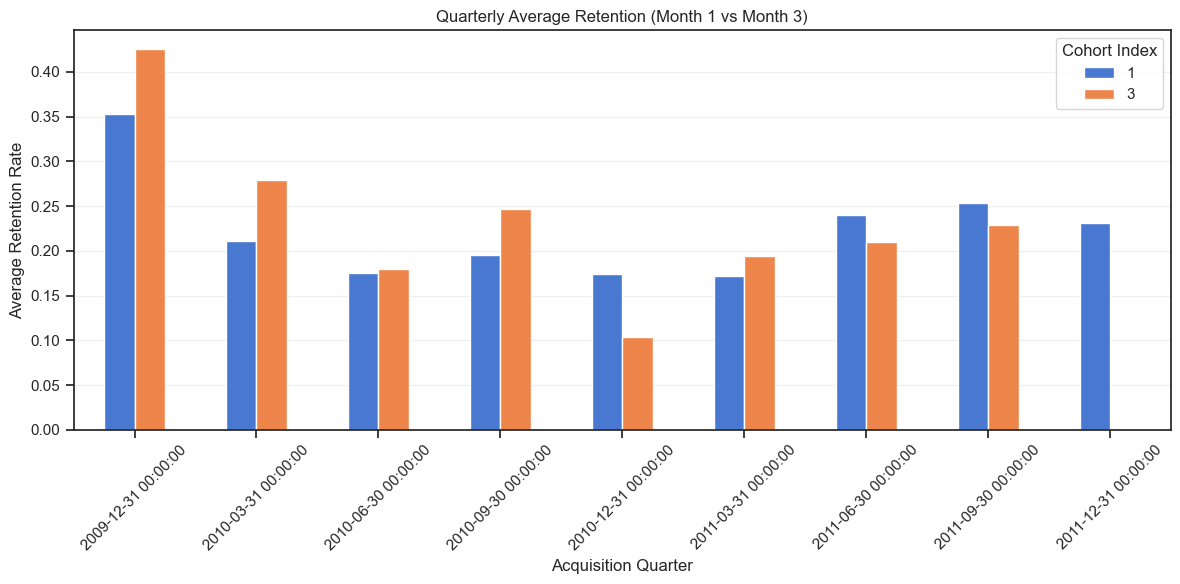

In [15]:
# Create Acquisition Month Cohort #export CSV
clean_df['AcquisitionMonth'] = clean_df.groupby('customer_id')['invoicedate'].transform('min').dt.to_period('M')
clean_df['OrderMonth'] = clean_df['invoicedate'].dt.to_period('M')

# Calculate Cohort Index (months since acquisition)
clean_df['CohortIndex'] = (clean_df['OrderMonth'] - clean_df['AcquisitionMonth']).apply(lambda x: x.n)

# Create Cohort Table
cohort_data = clean_df.pivot_table(index='AcquisitionMonth', columns='CohortIndex', values='customer_id', aggfunc=pd.Series.nunique)

# Calculate Retention Rate
cohort_size = cohort_data.iloc[:,0]
retention_table = cohort_data.divide(cohort_size, axis=0).round(3)
retention_table.to_csv('Customer_retention_table.csv', index=False)
#print(retention_table.head(10))
# --- Group cohorts by quarter ---
quarterly_retention = retention_table.copy()
quarterly_retention.index = quarterly_retention.index.to_timestamp()  # Convert PeriodIndex to Timestamp
quarterly_retention = quarterly_retention.resample("Q").mean()  # Average retention per quarter

# Select key months to compare (e.g., Month 1 and Month 3)
months_to_compare = [1, 3]
quarterly_selected = quarterly_retention[months_to_compare]



plt.figure(figsize=(10, 6))
quarterly_selected.plot(kind="bar", figsize=(12, 6))
plt.title("Quarterly Average Retention (Month 1 vs Month 3)")
plt.xlabel("Acquisition Quarter")
plt.ylabel("Average Retention Rate")
plt.legend(title="Cohort Index")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Key Observations

- Strong Initial Retention in Q4 2009

Month 1: (35%)
Month 3: (42%) unusually high, suggesting a very loyal early user base or strong seasonal demand.

- Retention Drop in Early 2010

Q1 2010 experienced sharp drop in average retention rate: Month 1 retention falls to 21%. Month 3 retention falls even more dramatically (0.28).

Q2 2010 hits the lowest point for Month 3 retention (almost equal to Month 1, 17%), showing very weak long-term engagement.

- Recovery & Stability from Late 2010

Q3 and Q4 2010 show slight improvements but Month 3 Q4 retention remains volatile. Q4 2010 has the lowest Month 3 retention overall (10%), many users are churning between month 1 and month 3.

- Significant Improvement in 2011

Both Month 1 and Month 3 retention improve steadily from Q2 2011 onwards. By Q3 2011, Month 1 retention peaks (26%, highest since early 2010). Month 3 retention nearly closes the gap with Month 1, suggesting better engagement strategies or improved product experience.


INSIGHTS

Onboarding & Early Churn Issues (2010): The steep drop in Month 1 retention in Q1–Q2 2010 suggests either:

- A shift in marketing brought in lower-quality leads.

- Product or onboarding changes reduced initial engagement.

- Seasonality: possibly fewer high-intent users after the holiday season.


Mid-Term Engagement Problem in Q4 2010:

-Very low Month 3 retention means users were not finding enough value to stick around after the first month.


Recovery and Improvement in 2011:

- Suggests interventions (better onboarding, improved product experience, targeted campaigns) were successful.

- Month 3 retention catching up to Month 1 is a great sign that indicates fewer users are leaving between months 1–3.


RECOMMENDATIONS
1. Maintain & Build on 2011 Improvements

Double down on whatever strategies caused the uptick in 2011: Improved onboarding flow?, Better customer support?, Product enhancements?, Re-engagement campaigns?

2. Investigate Early 2010 Drop

Look at acquisition channels, campaigns, and product changes in Q1–Q2 2010. Identify why user quality or experience dropped, and prevent repeating those mistakes.

3. Strengthen Month 3 Retention

Even in 2011, Month 3 retention is still slightly lower than Month 1. Strategies:Email/SMS nudges during months 1–3. Loyalty programs or milestone rewards after first purchase. Personalized product recommendations to keep users engaged.

4. Monitor Quarterly Trends Continuously

Continue to track quarterly averages. If Month 1 retention drops suddenly again, investigate acquisition strategy immediately.

Summary:
This data shows a temporary retention problem in early 2010, followed by a steady recovery in 2011. Month 1 retention is now at its highest since late 2009, which is excellent. Focus now should be on closing the gap between Month 1 and Month 3 retention, ensuring users continue engaging after the first month to drive higher LTV (lifetime value).

# AVERAGE ORDER VALUE BY COUNTRY

Overall AOV: 479.95


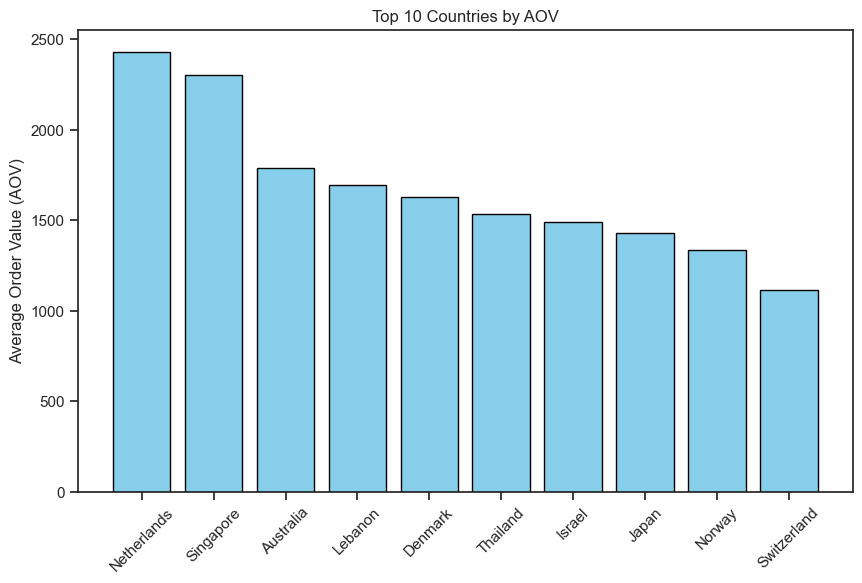

In [16]:
# Calculate Overall AOV 
overall_aov = clean_df['totalsales'].sum() / clean_df['invoice'].nunique()
print(f"Overall AOV: {overall_aov:.2f}")

# Calculate AOV by Customer Segment (e.g., Country)
aov_by_segment = clean_df.groupby('country').agg(
    Total_Revenue=('totalsales', 'sum'),
    Number_of_Orders=('invoice', 'nunique'))
aov_by_segment['AOV'] = aov_by_segment['Total_Revenue'] / aov_by_segment['Number_of_Orders']
#print(aov_by_segment.sort_values('AOV', ascending=False).head())


# Sort by AOV and take top 10 countries
top_aov = aov_by_segment.sort_values('AOV', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top_aov.index, top_aov['AOV'], color='skyblue', edgecolor='black')
plt.xticks(rotation=45)
plt.ylabel("Average Order Value (AOV)")
plt.title("Top 10 Countries by AOV")
plt.show()





INSIGHTS

- High AOV Outliers: Singapore (1211.13), Norway (453.30), Malta (418.67) has very high average order values compared to the global average (70). But there were very few orders (Singapore: 11, Malta: 9), these could be bulk purchases or wholesale clients.

- Large Revenue Contributors: Ireland (€83,687, AOV 147.60, 567 orders), France (€58,922, AOV 96.08, 614 orders), Spain (€15,781, AOV 102.48, 154 orders). These countries combine higher order counts + decent AOV, driving strong revenues.

- Medium Revenue + Mid AOV: Switzerland (€11,530, 90 orders, AOV 128.11), Belgium (€13,064, 149 orders, AOV 87.28), Reliable but smaller markets than Ireland/France.

- Low AOV Countries

Bahrain (AOV 42.63), Czech Republic (19.14), Japan (29.48) are much lower than global average. Likely customers are buying small-value or few-item orders.

RECOMMENDATIONS

1. Leverage High AOV Countries like Singapore, Norway, Malta by targeting them as premium markets. Since they buy in large volumes per order, explore B2B partnerships or bulk-buy incentives. Even a small increase in order frequency will create a big revenue impact.

2. Double Down on Revenue Leaders like Ireland, France, Spain are the backbone markets (high volume + decent AOV). Invest in localized marketing, loyalty programs, and upselling to increase frequency. Potential to raise AOV further by bundling products (customers here already buy in good amounts).

3. Grow Medium Performers like Belgium, Switzerland, Portugal, Greece are moderate order numbers and mid AOV. Target with cross-sell campaigns (“Customers who bought X also bought Y”) to lift order values. Could be converted into strong revenue markets with the right push.

4. Address Low AOV Countries like Japan, Czech Republic, Bahrain, West Indies are low average order sizes. Introduce minimum order free shipping thresholds or bundle discounts to push customers to spend more per order. Example: “Free shipping over €50” nudges them closer to the global AOV of €70.


SUMMARY

Focus retention and growth in Ireland, France, Spain (high order volume, stable revenue).

Tap premium, bulk-buy opportunities in Singapore, Norway, Malta (very high AOV).

Improve AOV in low-value countries with promotions, shipping incentives, and product bundling.

# PREDICTING CUSTOMER CHURN/VALUE AND PROVIDING ROADMAP FOR CUSTOMER RETENTION AND REVENUE GROWTH

In [ ]:
# Business rule: Customer who havn't purchased in 100 days is considered churned
CHURN_THRESHOLD_DAYS = 100

rfm_df['Churned'] = (rfm_df['Recency'] > CHURN_THRESHOLD_DAYS).astype(int)

churn_rate = rfm_df['Churned'].mean() * 100
print(f"Overall churn rate: {churn_rate:.2f}%")
print(f"Churned customers: {rfm_df['Churned'].sum()}")
print(f"Active customers: {len(rfm_df) - rfm_df['Churned'].sum()}")
print(rfm_df['Churned'])
rfm_df.to_csv("rfm_customer_data.csv")


Overall churn rate: 49.32%
Churned customers: 2899
Active customers: 2979
0       1
1       0
2       0
3       0
4       1
       ..
5873    0
5874    1
5875    1
5876    1
5877    0
Name: Churned, Length: 5878, dtype: int64



Preparing data for machine learning...
Training set: 4702 samples
Test set: 1176 samples
Features used: 13

Training Random Forest Classifier for churn prediction...
-MODEL EVALUATION-
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       596
           1       1.00      1.00      1.00       580

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0
Standard Deviation: 0.0


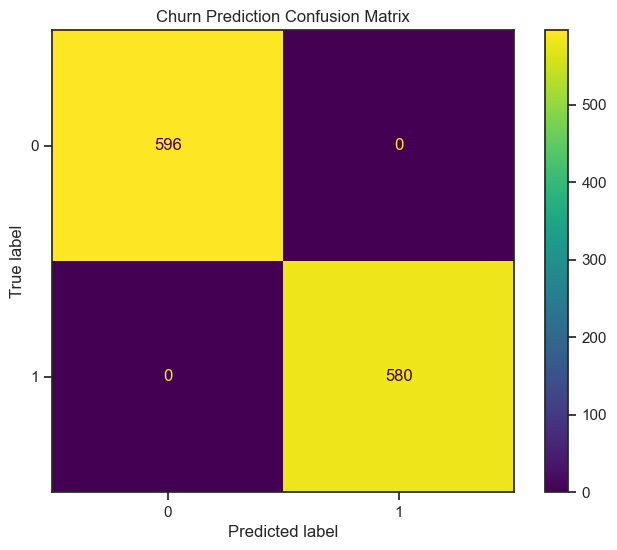


 Generating churn scores and action lists...

HIGH RISK CUSTOMERS LIST
Found 808 high-value customers at risk of churn
      Monetary  ChurnProbability         Country
5876   1296.43               1.0  United Kingdom
0     77556.46               1.0  United Kingdom
8      1079.40               1.0           Spain
23     1791.15               1.0         Austria
27     1127.65               1.0         Austria
31     3426.32               1.0     Switzerland
5858   1490.23               1.0  United Kingdom
5685   2303.09               1.0  United Kingdom
5675   1645.75               1.0  United Kingdom
5664   1509.04               1.0  United Kingdom
CUSTOMER SEGMENTATION ANALYSIS BASED ON CHURN RISK

CUSTOMER VALUE TIER AND THE LEVEL OF CHURN RISK
                               Count       AvgLTV  ChurnProbability
StrategicSegment ValueSegment                                      
Low Risk         Low              51   188.010980          0.024118
                 Medium           75 

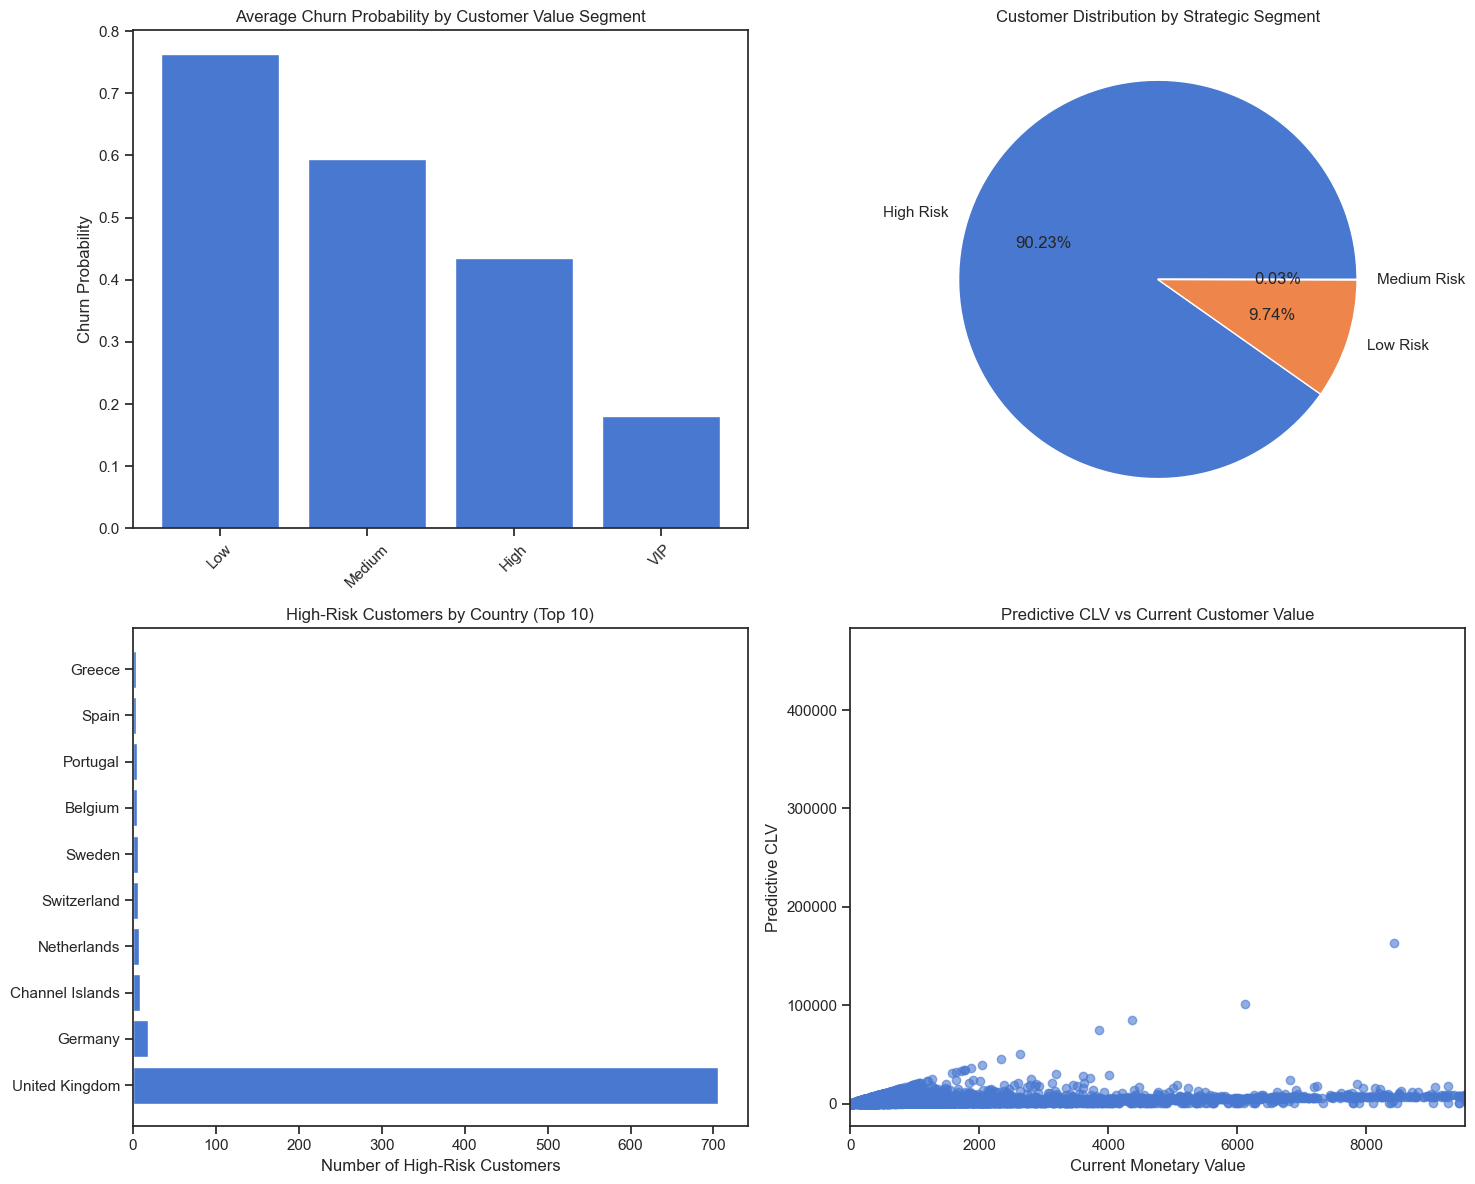


STEP 9: Exporting actionable data for RevOps teams...

=== ANALYSIS COMPLETE ===
✓ RFM analysis for 5878 customers
✓ Churn prediction model trained (Accuracy: 100.00%)
✓ 808 high-risk customers identified
✓ Predictive CLV calculated for all customers
✓ Files exported: 'revops_customer_actions.csv', 'high_risk_customers_detailed.csv'

*** RECOMMENDED NEXT ACTIONS ***
1. Prioritize outreach to high-risk, high-value customers
2. Develop retention campaigns for medium-risk segments
3. Analyze country-specific patterns for localized strategies
4. Monitor model performance monthly and retrain with new data


In [ ]:
#  PREPARE DATA FOR MODELING

print("\nPreparing data for machine learning...")

model_data = rfm_df.copy()

# Encode country as categorical variable
model_data['CountryCode'] = pd.factorize(model_data['Country'])[0]

# Select features for model
features = [
    'Recency', 'Frequency', 'Monetary', 'Avgordervalue', 'Purchasecycle',
    'Tenure', 'FreqLast5M', 'MonetaryLast5M', 'QuantityLast5M', 'AvgOrderValueLast5M',
    'FreqChangeRatio', 'ValueChangeRatio', 'CountryCode'
]

X = model_data[features]
y = model_data['Churned']

# Handle any remaining missing values
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features used: {len(features)}")

# TRAIN CHURN PREDICTION MODEL

print("\nTraining Random Forest Classifier for churn prediction...")

# Initialize and train model
churn_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
churn_model.fit(X_train, y_train)

# Evaluate model
y_predict = churn_model.predict(X_test)
y_predict_probability = churn_model.predict_proba(X_test)[:, 1]

print("-MODEL EVALUATION-")
print(classification_report(y_test, y_predict))

# Evaluate accuracy with 5-fold cross-validation
cv_scores = cross_val_score(churn_model, X, y, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))


# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(churn_model, X_test, y_test, ax=ax)
plt.title('Churn Prediction Confusion Matrix')
plt.show()


# GENERATE CHURN SCORES & ACTION LISTS
print("\n Generating churn scores and action lists...")

# Get predictions for all customers
model_data['ChurnProbability'] = churn_model.predict_proba(X)[:, 1]
model_data['PredictedChurn'] = churn_model.predict(X)

# Create actionable segments
model_data['ValueSegment'] = pd.qcut(model_data['Monetary'], q=4, labels=['Low', 'Medium', 'High', 'VIP'])

# Define high-risk customers: High probability of churn AND high value
HIGH_RISK_THRESHOLD = 0.7  # 70% probability
HIGH_VALUE_THRESHOLD = 1000  # 1000+ total value

high_risk_customers = model_data[(model_data['ChurnProbability'] >= HIGH_RISK_THRESHOLD) & (model_data['Monetary'] 
>= HIGH_VALUE_THRESHOLD)].sort_values('ChurnProbability', ascending=False)

print(f"\nHIGH RISK CUSTOMERS LIST")
print(f"Found {len(high_risk_customers)} high-value customers at risk of churn")
print(high_risk_customers[['Monetary', 'ChurnProbability', 'Country']].head(10))

print(f'CUSTOMER SEGMENTATION ANALYSIS BASED ON CHURN RISK')
model_data['StrategicSegment'] = pd.cut(model_data['ChurnProbability'], bins=[0, 0.3, 0.7, 1], 
labels=['Low Risk', 'Medium Risk', 'High Risk'])

# Analyze segments
segment_analysis = model_data.groupby(['StrategicSegment', 'ValueSegment']).agg({
    'customer_id': 'count', 'Monetary': 'mean', 'ChurnProbability': 'mean'
}).rename(columns={'customer_id': 'Count', 'Monetary': 'AvgLTV'})

print("\nCUSTOMER VALUE TIER AND THE LEVEL OF CHURN RISK")
print(segment_analysis)


# PREDICTING CUSTOMER LIFETIME VALUE
print("\nCalculating Predictive Customer Lifetime Value...")

model_data['AvgMonthlyValue'] = model_data['Monetary'] / (model_data['Tenure'] / 30 + 1)  # Avoid division by zero
#model_data['ExpectedLifetimeMonths'] = 1 / (model_data['ChurnProbability'] + 0.01)  # Smoothing
#model_data['PredictiveCLV'] = model_data['AvgMonthlyValue'] * model_data['ExpectedLifetimeMonths']

model_data['ExpectedLifetimeMonths'] = 1 / (model_data['ChurnProbability'] + 0.01)
model_data['ExpectedLifetimeMonths'] = model_data['ExpectedLifetimeMonths'].clip(upper=24)
discount_rate = 0.01  # 1% per month

model_data['PredictiveCLV'] = (
    model_data['AvgMonthlyValue'] * model_data['ExpectedLifetimeMonths']
) / (1 + discount_rate * model_data['ExpectedLifetimeMonths'])


# CUSTOMER LIFETIME VALUE PREDICTION CSV
top_future_customers = model_data[model_data['PredictiveCLV'] > 0].sort_values(
    'PredictiveCLV', ascending=False).head(10)

print("\n-TOP 10 FUTURE VALUABLE CUSTOMERS-")
print(top_future_customers[['Monetary', 'ChurnProbability', 'PredictiveCLV', 'Country']])

# VISUALIZATION & REPORTING


print("\nCreating visualizations for stakeholders...")

# Dashboard-style visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Churn Risk by Value Segment
risk_by_value = model_data.groupby('ValueSegment')['ChurnProbability'].mean()
axes[0, 0].bar(risk_by_value.index.astype(str), risk_by_value.values)
axes[0, 0].set_title('Average Churn Probability by Customer Value Segment')
axes[0, 0].set_ylabel('Churn Probability')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Customer Distribution by Strategic Segment
strategic_counts = model_data['StrategicSegment'].value_counts()
axes[0, 1].pie(strategic_counts.values, labels=strategic_counts.index, autopct='%1.2f%%')
axes[0, 1].set_title('Customer Distribution by Strategic Segment')

# 3. High-Risk Customers by Country
high_risk_by_country = high_risk_customers['Country'].value_counts().head(10)
axes[1, 0].barh(high_risk_by_country.index, high_risk_by_country.values)
axes[1, 0].set_title('High-Risk Customers by Country (Top 10)')
axes[1, 0].set_xlabel('Number of High-Risk Customers')

# 4. Predictive CLV vs Current Value
axes[1, 1].scatter(model_data['Monetary'], model_data['PredictiveCLV'], alpha=0.6)
axes[1, 1].set_xlabel('Current Monetary Value')
axes[1, 1].set_ylabel('Predictive CLV')
axes[1, 1].set_title('Predictive CLV vs Current Customer Value')
axes[1, 1].set_xlim(0, model_data['Monetary'].quantile(0.95))  # Remove extreme outliers

plt.tight_layout()
plt.show()

# 9. EXPORT ACTIONABLE INSIGHTS

print("\nSTEP 9: Exporting actionable data for RevOps teams...")

# Create export data for sales/marketing teams
action_export = model_data[[
    'customer_id', 'Monetary', 'ChurnProbability', 'PredictedChurn', 
    'ValueSegment', 'StrategicSegment', 'PredictiveCLV', 'Country'
]].copy()

action_export['ActionPriority'] = pd.cut(
    action_export['ChurnProbability'],
    bins=[0, 0.3, 0.7, 0.9, 1],
    labels=['Monitor', 'Email Nurture', 'Personal Outreach', 'Urgent Action']
)

# Save to CSV for operational teams
#action_export.to_csv('revops_customer_actions3.csv', index=True)
#high_risk_customers.to_csv('high_risk_customers_detailed.csv')
#segment_analysis.to_csv('segment.csv')

print("\n=== ANALYSIS COMPLETE ===")
print(f"✓ RFM analysis for {len(rfm_df)} customers")
print(f"✓ Churn prediction model trained (Accuracy: {churn_model.score(X_test, y_test):.2%})")
print(f"✓ {len(high_risk_customers)} high-risk customers identified")
print(f"✓ Predictive CLV calculated for all customers")
print(f"✓ Files exported: 'revops_customer_actions.csv', 'high_risk_customers_detailed.csv'")

print("\n*** RECOMMENDED NEXT ACTIONS ***")
print("1. Prioritize outreach to high-risk, high-value customers")
print("2. Develop retention campaigns for medium-risk segments")
print("3. Analyze country-specific patterns for localized strategies")
print("4. Monitor model performance monthly and retrain with new data")



# Executive Summary & Recommendations
 Objective

The goal of this analysis was to understand customer behavior, revenue drivers, and sales trends for a retail store, diagnose the causes of major fluctuations, and recommend strategies to improve revenue, retention, and customer lifetime value (CLV).

# Key Insights
1. Customer Behavior & Segmentation

5,878 unique customers shopped over the two-year period.

27.6% of customers are one-time buyers; a significant churn risk.

Repeat customers generate the bulk of revenue, indicating that loyalty and retention are key revenue drivers.

2. Sales & Revenue Distribution

Most purchases are small basket transactions (1–10 items), meaning sales are driven by high frequency of small orders, not bulk buys.

Price distribution skews toward mid-range (£10–£100), with only a few high-priced outliers.

Revenue is concentrated among top-spending customers, meaning a small percentage of customers are disproportionately valuable.

3. Seasonality & Trends

Clear seasonality: Revenue consistently spikes in Q4, peaking in November 2010 (£1.17M).

February consistently underperforms, indicating a potential demand slump after holiday seasons.

2010 outperformed 2011 overall, suggesting slowing growth or weaker campaign execution in the second year.

4. Revenue Drivers (Diagnostic Analysis)

New customers contributed only marginally to peak revenue months, meaning growth was driven mainly by existing customers spending more.

Product-led growth and upsell/cross-sell campaigns likely contributed to peak months; this is a positive sign of healthy retention and marketing ROI.

There is opportunity to expand acquisition efforts, as dependence on repeat spenders is high.

# Business Implications

This retail store’s growth is powered by loyal, repeat customers who increase spending during key seasons (especially November). However, one-time buyer churn and seasonality dips (notably February) are limiting steady revenue growth. The business could unlock significant value by:

Improving customer retention of first-time buyers.

Launching campaigns outside peak months to smooth revenue seasonality.

Leveraging insights about high-value customers and products to drive more targeted campaigns.

# Actionable Recommendations

1. Revenue Growth

Diversify campaigns: Launch mid-year promotions (e.g., Valentine’s, back-to-school) to combat February and Q2 dips.

Seasonal demand planning: Stock and market products heavily leading into Q4 since it’s the highest-performing quarter.

2. Customer Retention

Target one-time buyers: Create automated follow-up emails or discount offers for first-time customers to encourage a second purchase.

Loyalty Program: Reward repeat buyers with tiered benefits (free shipping, early access) to increase frequency and AOV.

3. High-Value Customer Focus

Identify the top 20% of customers (“VIPs”) and offer exclusive offers or personalized recommendations to maintain and grow their spend.

4. Product Strategy

Double down on bestsellers: Promote the top 10 revenue-generating products more aggressively.

Introduce bundling offers or curated seasonal packages to increase basket size.

5. Ongoing Measurement

Monitor cohort retention rates quarterly to measure if retention strategies are working.


# Summary

This retail store is powered by loyal, repeat buyers, with peak performance in Q4. However, over a quarter of customers churn after their first purchase, and February represents a consistent slump. By improving first-time buyer retention, incentivizing repeat purchase behavior, and strategically planning campaigns outside peak season, the business can unlock steady, predictable growth while maximizing the lifetime value of its most profitable customers.

# Thank you for checking out my work. 

Contact me: deborahokorohdavid@gmail.com